# Визуальный анализ профессий

## Цель исследования

На этапе [исследовательского анализа данных](eda.ipynb) мы видели, что ответ на открытый вопрос "Кем ты рабоатешь" представлен 20 тыс. значениями с неравномерным распределением. Есть 10% часто встречающихся вариантов ответов, есть 3/4 вариантов, встречающихся по 1 разу. 

Наша задача для каждого ответа найти самое близкое значение в классификаторе профессий, содержащим ограниченное множество значений. 

В общем случае нам надо найти функцию преобразования ответа $\alpha$ в значение профессии $\kappa$ из справочника профессий $k$

$\kappa = f(\alpha, k)$

так, чтобы расстояние между этими значениями стремилось к нулю:

$D(\alpha, \kappa) \rightarrow 0$

При этом функция $f$ должна обладать таким свойством, что схожие по значению документы (ответы и/или профессии) в вектроном пространстве находятся рядом, а разные по значению -- далеко друг от друга.

Рассмотрим подход к решению, основанный на преобразовании текстов в численные многомерные вектора (эмбеддинги), позволяющий нам оперировать понятием расстояния между словами через математические функции.

Проверим, что функция преобразования текстов в эмбединги позволяет нам получить близкие по смыслу документы рядом, а разные по смыслу — далеко друг от друга.

## Данные

Данные анкет после EDA и предобработки находятся в файле ```../datasets/intermediate/df_duplicates_isna_processed.csv```.

Из интервью с заказчиком мы знаем, что в конце датасета находятся записи из B2B-версии сервиса, в котором ответы на вопросы давали только сотрудники компаний. Сформулируем гипотезу, что в этой части данных ответы на вопросы будут иметь меньше шума.

Классификаторы профессий возьмем с ведущекго карьерного сервиса в России [hh.ru](https://hh.ru). У сервиса есть [API](https://dev.hh.ru), позволяющих загрузить справочники в JSON формате без авторизации.

На hh.ru есть два справочника, имеющих отношение к профессиям:
- справочник всех [профессиональных областей и специализаций](https://github.com/hhru/api/blob/master/docs/specializations.md), который компания называет устаревшим;
- и [справочник профессиональных ролей](https://api.hh.ru/openapi/redoc#tag/Obshie-spravochniki/paths/~1professional_roles/get), пришедший на смену специализациям.

Получить эти справочники можно GET-запросом к API:

```curl -k -H 'User-Agent: api-test-agent' 'https://api.hh.ru/professional_roles'```

```curl -k -H 'User-Agent: api-test-agent' 'https://api.hh.ru/specializations'```

## Подготовка кода

### Загрузка библиотек

In [1]:
import requests
import re

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from gensim.models import fasttext

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
import pymorphy2

### Константы

In [7]:
MA = pymorphy2.MorphAnalyzer()

In [8]:
RE_NON_LETTERS = re.compile('\W')
RE_MULTISPACE = re.compile('\s+')

In [9]:
STOP_WORDS = ['менеджер', 'работа', 'специалист', 
              'руководитель', 'отдел', 'оператор',
              'начальник', 'группа', 'оператор', 'другой' ]

### Функции

#### concat_prof

In [10]:
def concat_prof(row: pd.DataFrame) -> str:
    '''Объединяет в одну строку название категории и название профессии для строки row
    '''
    return row.category_name.lower() + ' ' + row.prof_name.lower()

#### preprocess

In [11]:
def preprocess(sentence: str) -> str:
    '''Удаляет все небуквенные символы и разбивает строку по пробелам'''
    sentence = RE_NON_LETTERS.sub(' ', sentence)
    sentence = RE_MULTISPACE.sub(' ', sentence)
    
    return sentence.lower().strip().split(' ')

#### normalize_tokens

In [12]:
def normalize_tokens(tokens: list) -> list:
    '''Оставляет среди токенов только существительные и прилагательные в нормальной форме
    '''
    words = []
    for word in tokens:
        p = MA.parse(word)[0]
        if 'NOUN' in p.tag or 'ADJF' in p.tag:
            words.append(p.normal_form)
    return words    

#### remove_stopwords

In [13]:
def remove_stopwords(documents: list) -> list:
    docs = []
    for doc in documents:
        tokens = [t for t in doc if t not in STOP_WORDS]
        docs.append(tokens)
    return docs

#### remove_empty_docs

In [14]:
def remove_empty_docs(labels: list, docs: list) -> tuple:
    '''Удаляет строки с пустыми документами'''
    ls = []
    ds = []
    for  label, doc in zip(labels, docs):
        if len(doc) > 0:
            ls.append(label)
            ds.append(doc)
    return ls, ds

#### unique_docs

In [15]:
def unique_docs(labels: list, docs: list) -> tuple:
    '''Для уникальных документов объединяет метки'''
    ls = []
    ds = []
    ds_dict = dict()
    for i, (label, doc) in enumerate(zip(labels, docs)):
        doc_key = '_'.join(doc)
        if doc_key in ds_dict:
            ls[ds_dict[doc_key]] += f', {label}'
        else:
            ds_dict[doc_key] = i
            ls.append(label)
            ds.append(doc)
    return ls, ds

#### tokenize_texts

In [16]:
def tokenize_texts(texts: list, normalize=False) -> list:
    '''Разбивает строку на слова'''
    docs = [preprocess(sentence.strip()) for sentence in texts if sentence.strip() != '']
    docs = [doc for doc in docs if len(doc) > 0]
    if normalize:
        docs = [normalize_tokens(doc) for doc in docs]
    return docs

#### sentence_2_vec

In [17]:
def sentence_2_vec(model: fasttext.FastTextKeyedVectors, sentence: list) -> np.array:
    '''Преобразует предложение как массив слов в вектор как сумму векторов каждого слова
    '''
    vectors = [model.get_vector(word) for word in sentence]

    return np.sum(vectors, axis=0)

#### docs_2_vec

In [18]:
def docs_2_vec(model: fasttext.FastTextKeyedVectors, documents: list) -> np.array:
    '''Преобразует список документов в список соответсвующих им векторов
    '''
    vectors = []
    for sentence in documents:
        vectors.append(sentence_2_vec(model, sentence))
        
    return vectors

#### display_pca_scatterplot

In [19]:
def display_pca_scatterplot(vectors: np.array, 
                            labels: list, 
                            label: str,
                            color: str, 
                            n_labels: int = 0,
                            alpha: float = 1.0
                           ) -> None:
    twodim = PCA().fit_transform(vectors)[:,:2]
    
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color, alpha=alpha, label=label)
    
    if n_labels:
        idxs = np.random.choice(len(labels), n_labels, replace=False)
        for i in idxs:
            x, y = twodim[i]
            
            plt.text(x+0.01, y+0.005, 
                     labels[i], 
                     alpha = alpha, c=color,
                     fontsize='xx-small'
                    )

#### hh_profession_labels

In [20]:
def hh_profession_labels(raw_list: list, keep_abbreviation=False) -> list:
    labels = dict()
    r = re.compile('(.+)\(([^\)]+)\)')
    for row in raw_list:
        for v in row.split(','):
            match = r.search(v)
            if match:
                v = match.group(1)
                
            v_stripped = v.strip().lower()

            if v_stripped not in labels:
                labels[v_stripped] = 1
            
            if keep_abbreviation and match and match.group(2) not in labels:
                labels[match.group(2)] = 1
    
    return list(labels.keys())

#### export_to_projector

In [21]:
def export_to_projector(data: list, filename: str) -> pd.DataFrame:
    vectors = pd.DataFrame(np.concatenate(data, axis=0))
    vectors.to_csv(filename, sep='\t', header=False, index=False)
    return vectors

#### calculate_cosine_similarity

In [22]:
def calculate_cosine_similarity(v_input: list, v_output: list, input_labels: list) -> pd.DataFrame:
    '''Рассчитывает косинусное сходоство и преобразует результат в DataFrame'''
    '''Столбцы соответствуют входному вектору'''
    matrix = pd.DataFrame(cosine_similarity(v_input, v_output)).T
    matrix.columns = input_labels
    return matrix

#### matching_overview

In [23]:
def matching_overview(matrix: pd.DataFrame, 
                      inputs: list, 
                      inputs_docs: list,
                      targets: list,
                      targets_docs: list) -> pd.DataFrame:
    '''Формирует таблицу сопоставления строк значениям классификатора
    '''
    results = []
    for input_idx, (input_label, target_idx) in enumerate(zip(inputs, matrix.idxmax().to_list())):
        results.append([input_label, 
                        ' '.join(inputs_docs[input_idx]),
                        targets[target_idx],
                        ' '.join(targets_docs[target_idx]),
                        matrix[input_label].max(),
                        matrix[input_label].mean(),
                        matrix[input_label].sem()])

    result_df = pd.DataFrame(results, 
                             columns=[
                                 'input',
                                 'inout tokenized',
                                 'output', 
                                 'output tokenized',
                                 'max cos sim', 
                                 'mean cos sim', 
                                 'sem cos sim'])
    return result_df

## Загрузка данных

### Классификаторы hh.ru

In [24]:
roles_url = 'https://api.hh.ru/professional_roles'
user_agent = {'User-agent': 'yp-masterskaya/1.0'}

In [25]:
roles_json = requests.get(roles_url, headers = user_agent).json()

Преобразуем данные в DataFrame c плоской структурой (ID категории, название категории, ID профессии, название профессии) и сохраним их в проекте.

In [26]:
roles = []

prof_columns = ['category_id', 'category_name', 'prof_id', 'prof_name']

for row in roles_json['categories']:
    for subrow in row['roles']:
        roles.append([row['id'], row['name'], subrow['id'], subrow['name']])        

prof_roles = pd.DataFrame(roles, columns = prof_columns)

In [27]:
print('Профессиональных ролей: ', prof_roles.shape[0])

Профессиональных ролей:  215


In [28]:
prof_roles.to_csv('../datasets/external/hh_prof_roles.csv')

Справочники hh.ru загружены и сохранены. 

Мы получили 215 профессиональных ролей.

Мы оставили в данных идентификаторы категорий и профессий для дальнейшего исследования, если нам понадобится загрузка вакансий или резюме c hh.ru.

### Загрузка анкет

Загрузим данные после предобработки.

In [29]:
df = pd.read_csv('../datasets/intermediate/df_duplicates_isna_processed.csv', dtype={'psychotype': str})
df.shape

(149700, 134)

Выделим ответы на вопросы "Кем ты работаешь" (q61) и "Твоя работа позволяет тебе реализовать свои лучшие качества и способности?" (q62), а также время ответа на эти вопросы. 

In [30]:
df = df[['q61', 'q62', 't61', 't62']]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149700 entries, 0 to 149699
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   q61     149700 non-null  object 
 1   q62     149700 non-null  float64
 2   t61     149700 non-null  float64
 3   t62     149700 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.6+ MB


Преобразуем ответ q62 к целочисленному типу.

In [32]:
df = df.astype({'q62': 'int32'})

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149700 entries, 0 to 149699
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   q61     149700 non-null  object 
 1   q62     149700 non-null  int32  
 2   t61     149700 non-null  float64
 3   t62     149700 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 4.0+ MB


###  Разделение b2b и b2c данных

Из исследовательского анализа данных мы знаем, что начиная со строки 136206 в датасете находятся данные b2b-сервиса. При этом значение времени у этих ответов на вопросы одинаковое и мы можем его удалить. 

#### B2B

In [34]:
b2b_answers = df.loc[136206:, ['q61', 'q62']]
b2c_answers = df[:136206]
print('b2b shape: ', b2b_answers.shape)
print('b2c shape:', b2c_answers.shape)

b2b shape:  (13494, 2)
b2c shape: (136206, 4)


Посмотрим на распределение уникальных значений в группе B2B и B2C.

In [35]:
b2b_answers.q61.value_counts().head(15)

Учащиеся | Студент                                                                1427
Руководитель организации | Руководитель (торговля, посредничество)                 996
Коммуникация, продажи | Менеджер по работе с клиентами                             602
Коммуникация, продажи | Менеджер по продажам                                       587
Финансы | Бухгалтер                                                                385
Менеджер среднего звена (руководитель отдела) | Начальник коммерческого отдела     337
Руководитель организации | Владелец бизнеса                                        310
Коммуникация, продажи | Руководитель (торговля, посредничество)                    296
Специалисты | Экономист                                                            280
Администрирование | Офис-менеджер                                                  279
Специалисты | Консультант                                                          260
Персонал и обучение | HR-менеджер          

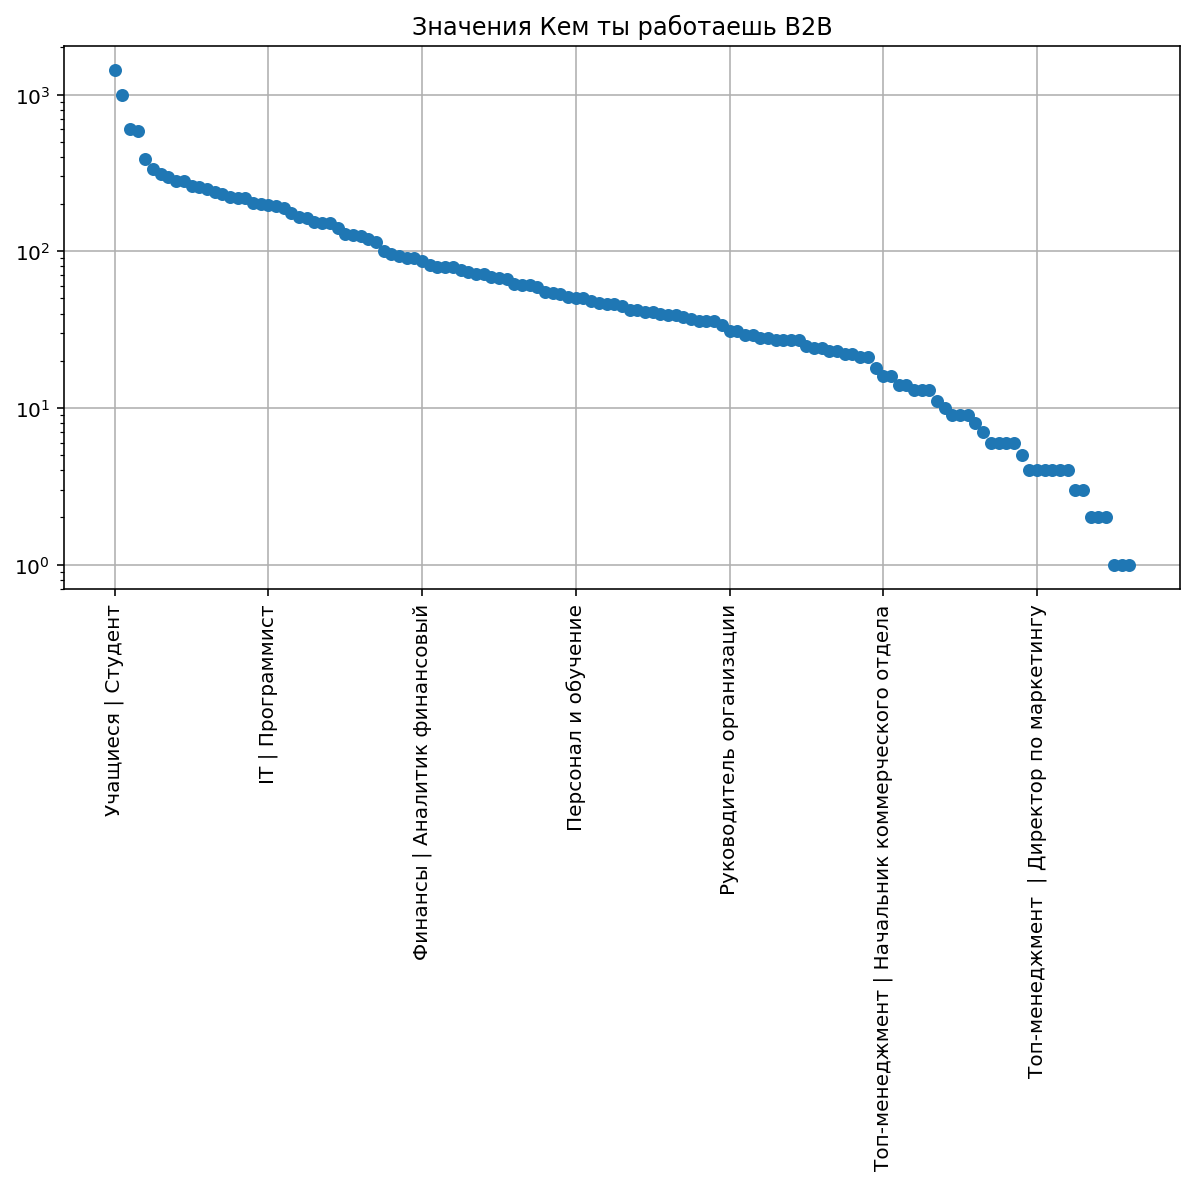

In [36]:
plt.figure(figsize=(10,5))
b2b_answers.q61.value_counts().plot(
    # Отобразим на графике в логарифмической шкале
    logy = True, title = 'Значения Кем ты работаешь B2B', lw = 0, marker='.', rot = 90,
    markersize = 11, grid = True)
plt.show()

Ответы в этом сегменте выглядят как значения закрытого справочника. Распеределение значений не является равномерным, однако имеет достаточное количество разных значений.

#### B2C

In [37]:
b2c_answers.q61.str.lower().value_counts().head(15)

никем         18222
студент        4798
учусь          3941
школьник       3624
ученик         3412
никем          3267
не работаю     1668
менеджер       1561
бухгалтер      1425
ни кем         1383
юрист          1362
учитель        1293
продавец       1271
школьником     1254
учусь          1223
Name: q61, dtype: int64

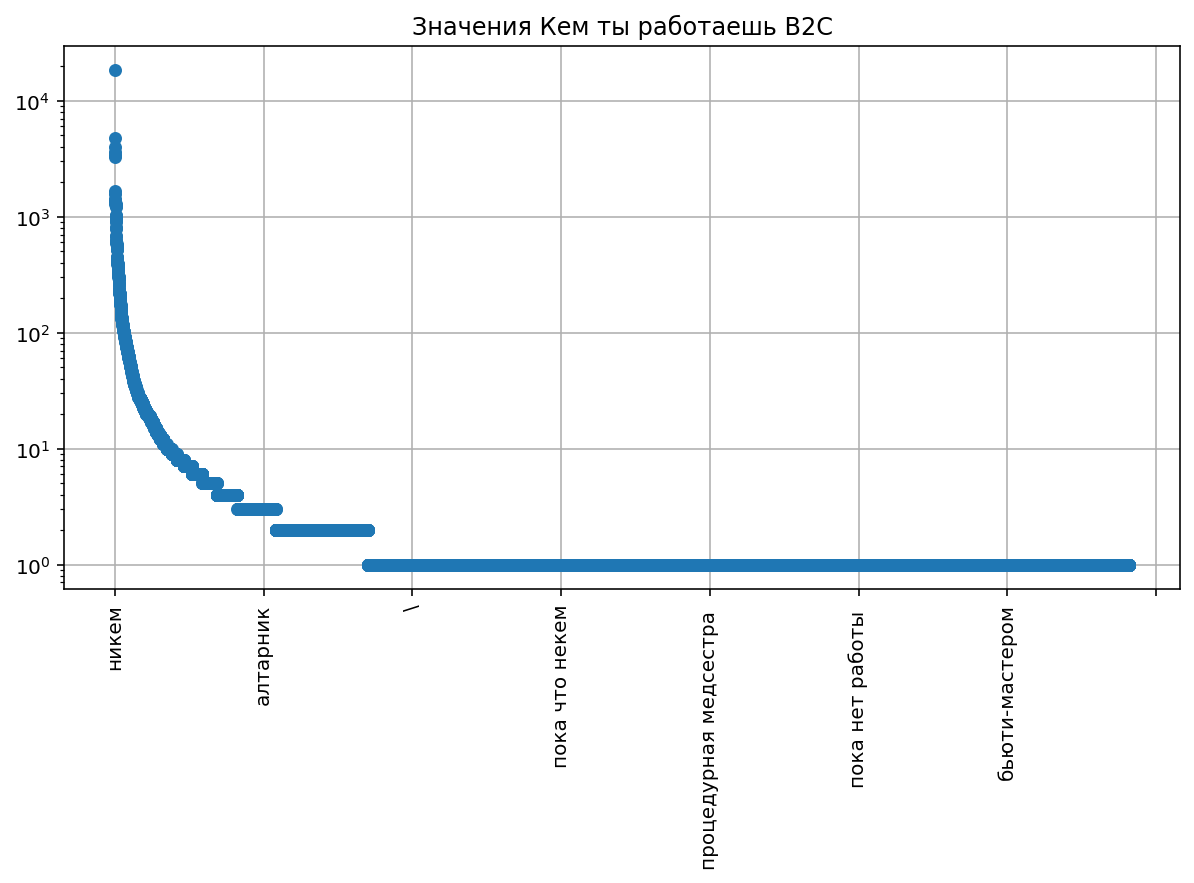

In [38]:
plt.figure(figsize=(10,5))
b2c_answers.q61.str.lower().value_counts().plot(
    # Отобразим на графике в логарифмической шкале
    logy = True, title = 'Значения Кем ты работаешь B2C', lw = 0, marker='.', rot = 90,
    markersize = 11, grid = True)
plt.show()

Видим значения, характерные для открытого вопроса. Большинство записей не относятся к профессиям (никем, учусь, не работаю). Видим длинный хвост редких значений.

#### Сохранение промежуточных данных

Сохраним ответы b2b и b2c.

In [39]:
b2b_answers.to_csv('../datasets/intermediate/b2b_answers.csv')
b2c_answers.to_csv('../datasets/intermediate/b2c_answers.csv')

### Выводы

Мы загрузили два классификтора профессий из сервиса hh.ru. 

Также мы видим, что ответы B2B-сегмента похожи на выбор из закрытого справочника профессий. 

В B2C ответы в свободной форме. Большинство ответов не релевантны профессии. 

Изучим представление этих 4 множеств в векторном пространстве.

## План исследования

Проверим гипотезу, что с помощью измрения косинусного расстояния между эмбедингами мы можем однозначно сопоставить строку, содержащую информацию о профессии, со значением из классификатора профессий. Для проверки гипотезы возьмем ответы на вопрос "Кем ты работаешь" b2b сегмента как менее шумного и сопоставим с профессиями из справочника профессиональных ролей hh.

1. Возьмем две предобученные модели FastText:
    - статическую модель [araneum_none_fasttextcbow_300_5_2018](https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz) на [RusVectors](https://rusvectores.org/ru/models/)
    - модель Facebook [FastText Russian](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz) на [Word vectors for 157 languages](https://fasttext.cc/docs/en/crawl-vectors.html)
2. Получим вектрное представление для 2 множеств докуменов, описывающих профессии: ответы b2b-сервиса как входные значения, профессиональные роли hh.ru как выходные значения. Вектор документа получим суммой векторов его токенов.
3. Сделаем визуальный анализ входных и выходных документов в векторном пространстве для оценки  разделения похожих и не похожих профессий.
6. Для каждого входного документа рассчитываем [косинусное расстояние](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) до каждого выходного документа. Выберем значение классификатора с минимальным расстоянием как подходящую профессию.
7. Изучим распределение расстояний и оценим состоятельность алгоритма сопоставления ответов на вопрос "Кем ты работаешь" и справочника профессий. 

## Преобразование в векторное пространство

### Загрузка моделей

Загрузим предобученные модели в формате [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [40]:
araneum_path = '../models/araneum/araneum_none_fasttextcbow_300_5_2018.model'
cc_ru_path = '../models/cc_ru_300_kv/cc_ru_300.kv'

In [41]:
a_model = fasttext.FastTextKeyedVectors.load(araneum_path)

In [42]:
c_model = fasttext.FastTextKeyedVectors.load(cc_ru_path)

### Преобразование

Преобразуем названия профессий в документы.

In [43]:
prof_roles_labels = prof_roles.apply(concat_prof, axis = 1).to_list()
prof_roles_docs = tokenize_texts(prof_roles_labels)

Преобразуем в документы уникальные значения.

In [44]:
b2b_labels = b2b_answers.q61.str.lower().unique()
b2b_docs = tokenize_texts(b2b_labels)

#### Модель Araneum

Преобразуем документы в вектора для разных моделей.

In [45]:
v_prof_roles_a = docs_2_vec(model = a_model, 
                            documents = prof_roles_docs)

In [46]:
v_b2b_a = docs_2_vec(model=a_model,
                     documents=b2b_docs)

#### Модель cc_ru

In [47]:
v_prof_roles_c = docs_2_vec(model = c_model, 
                            documents = prof_roles_docs)

In [48]:
v_b2b_c = docs_2_vec(model=c_model,
                     documents=b2b_docs)

## Визуализация

### Модель Araneum PCA Plot

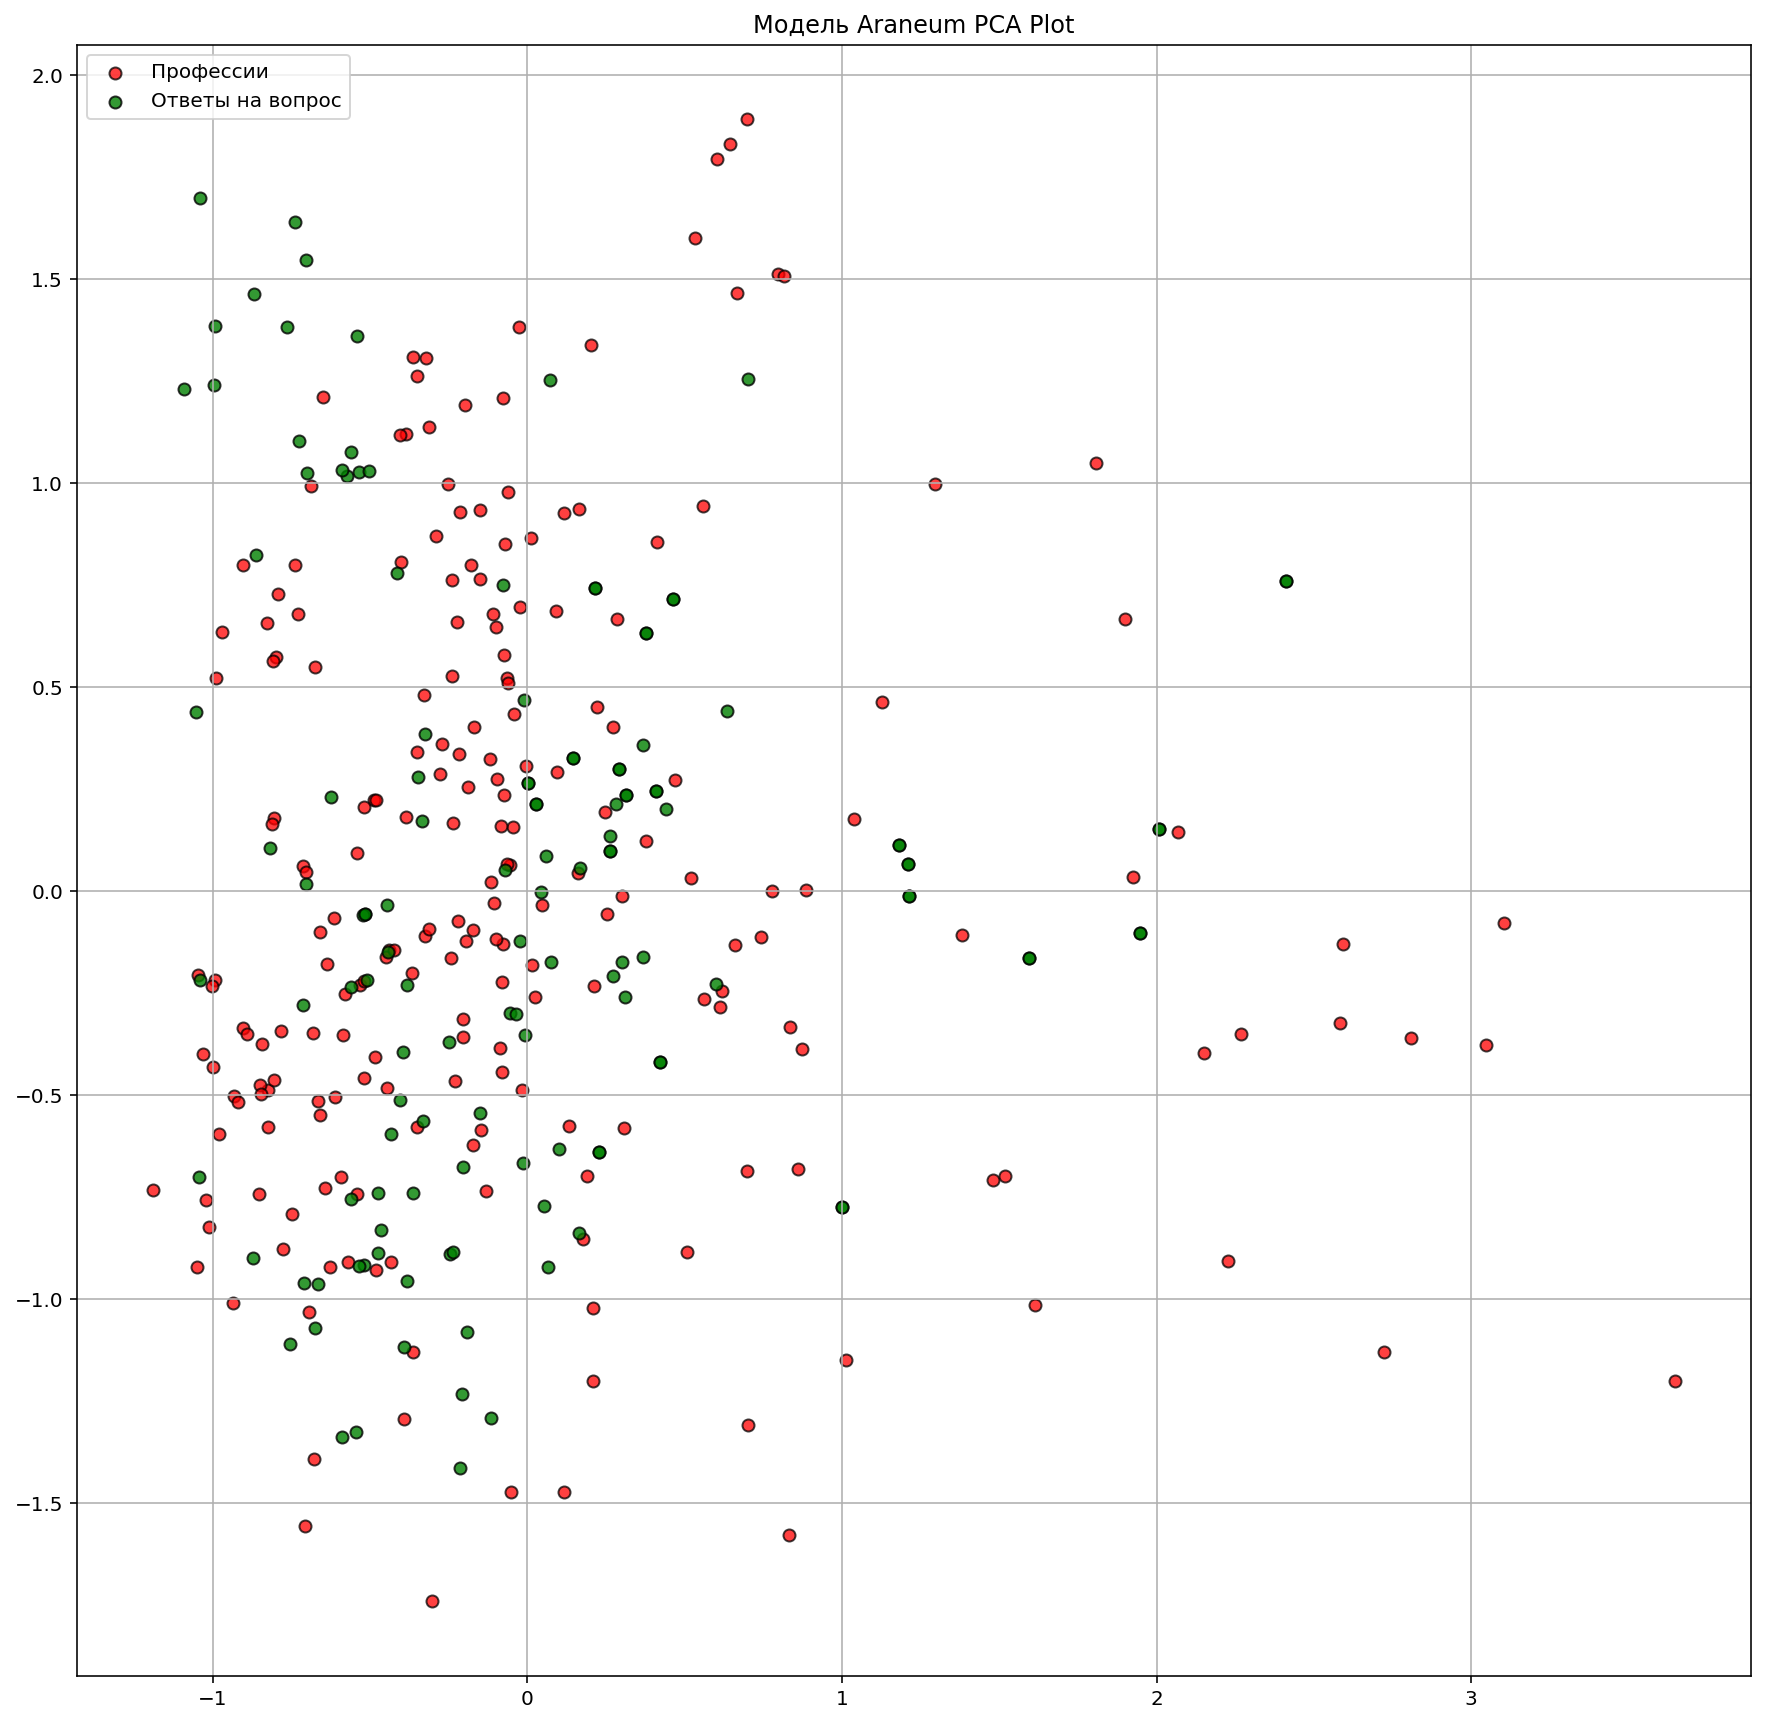

In [49]:
plt.figure(figsize=(15, 15))

# prof_roles
display_pca_scatterplot(vectors=v_prof_roles_a, 
                        labels=prof_roles_docs,
                        label='Профессии',
                        color='r', alpha=.75)

# b2b
display_pca_scatterplot(vectors=v_b2b_a, 
                        labels=b2b_docs,
                        label='Ответы на вопрос',
                        color='g', alpha=.8)

plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель Araneum PCA Plot')
plt.show()

### Модель cc_ru PCA Plot

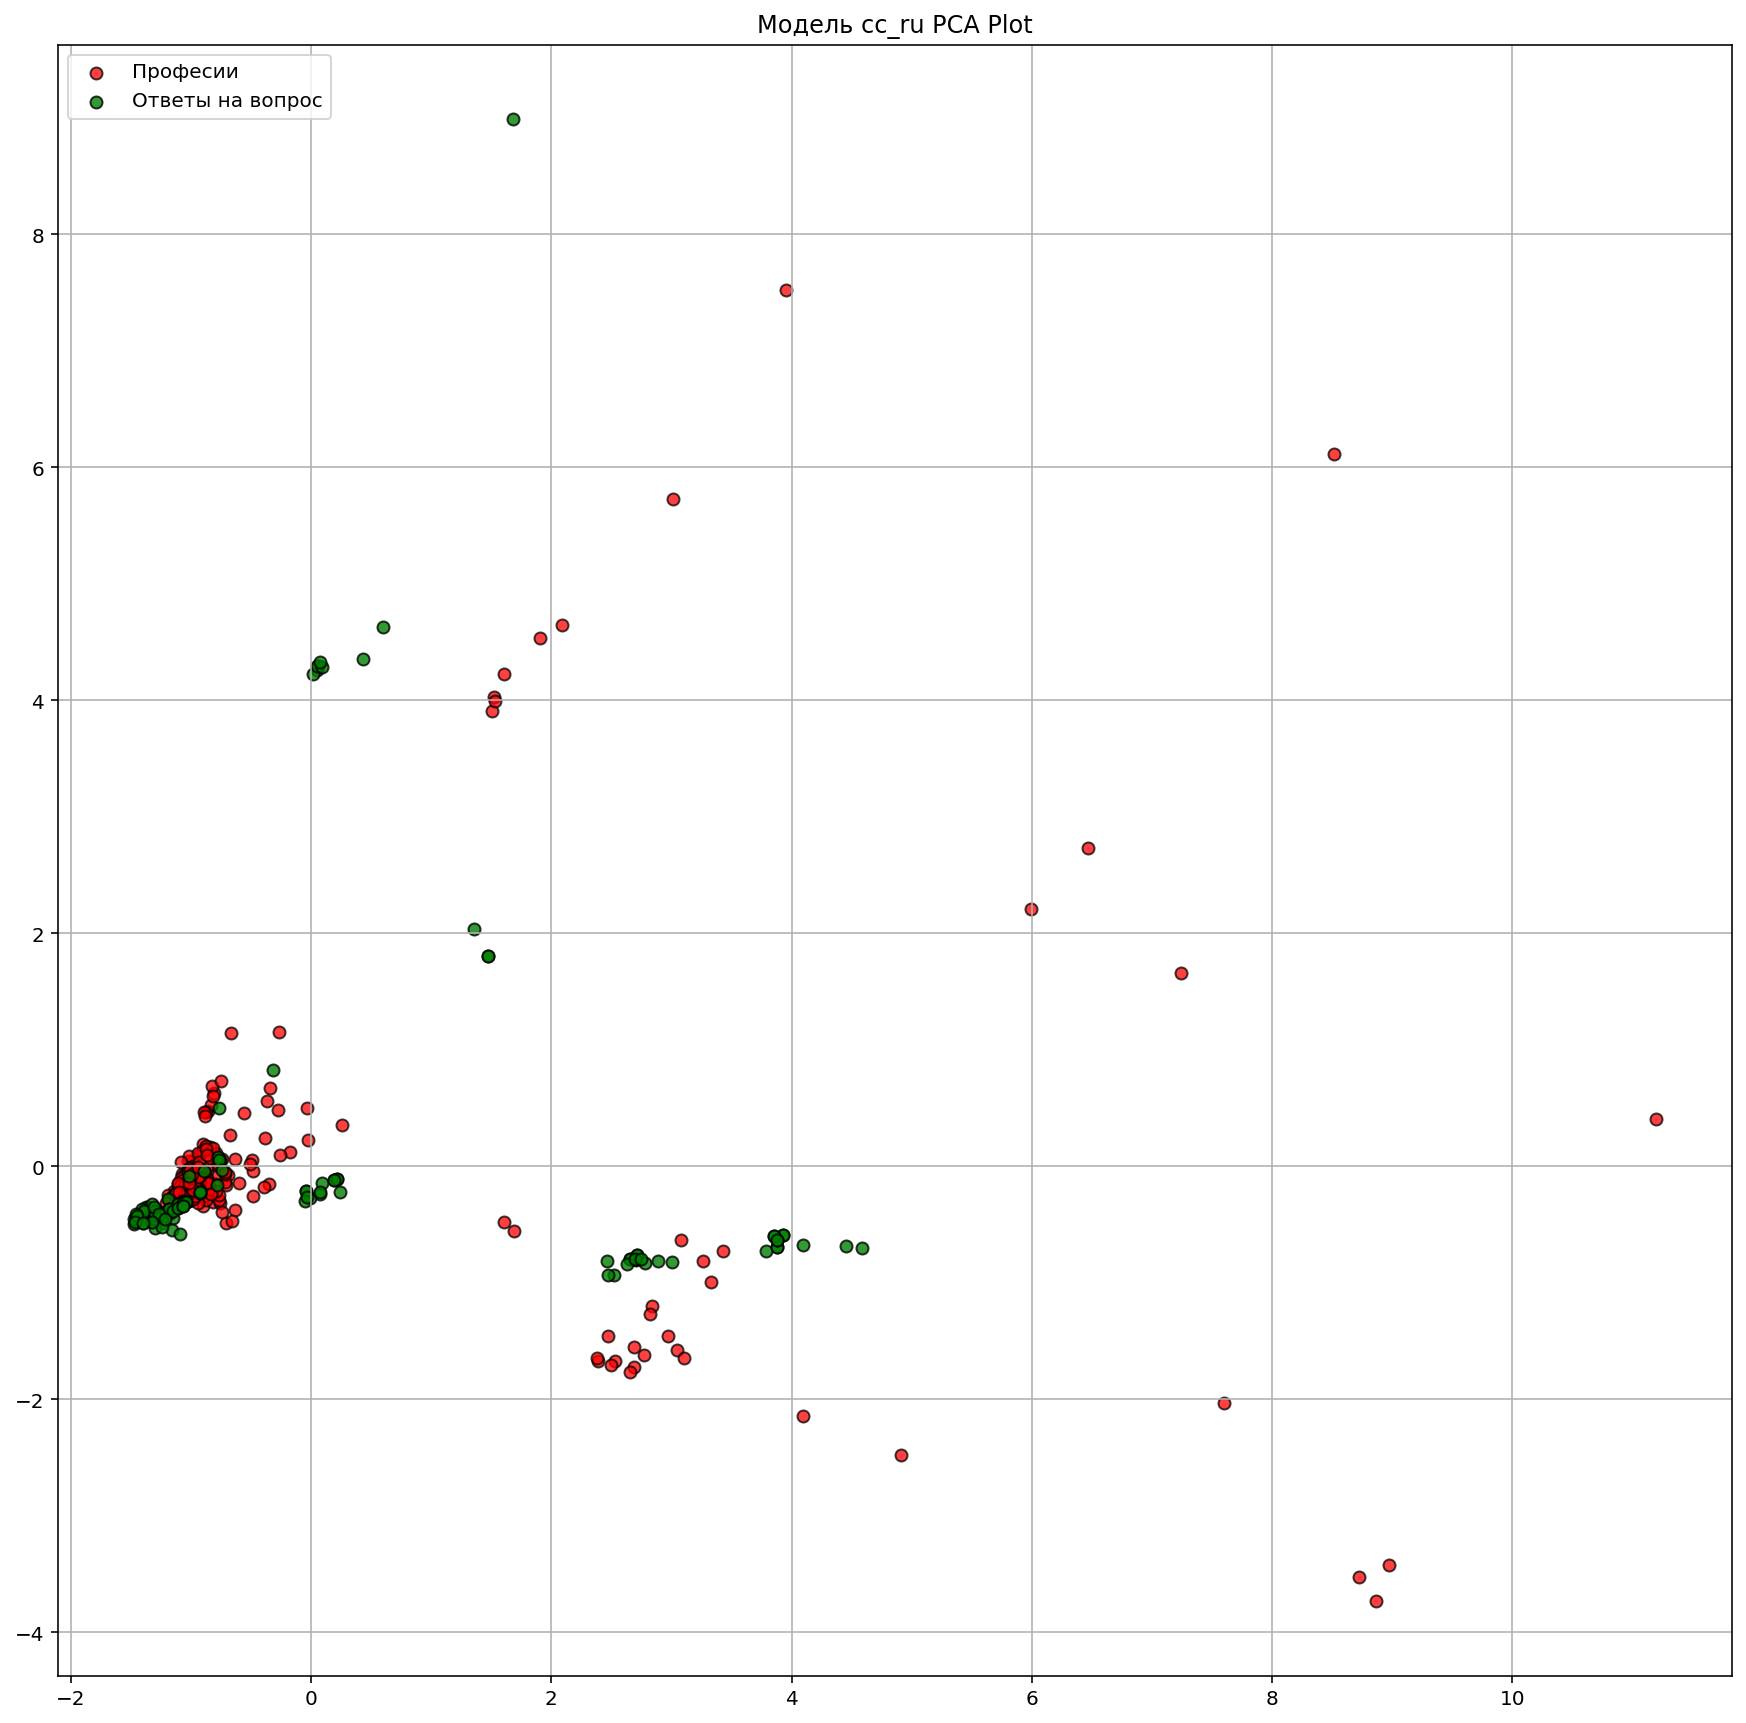

In [50]:
plt.figure(figsize=(15, 15))

# prof_roles
display_pca_scatterplot(vectors=v_prof_roles_c, 
                        labels=None,
                        label='Професии',
                        color='r', alpha=.75)

# b2b
display_pca_scatterplot(vectors=v_b2b_c, 
                        labels=None,
                        label='Ответы на вопрос',
                        color='g', alpha=.8)

plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель cc_ru PCA Plot')
plt.show()

На основании полученной визуализации мы не можем сделать вывод о пригодности или не пригодности подхода. Сделаем экспорт векторов для анализа в TensorFlow Embedding Projector.

## Сохранение векторов

Сохраним вектора в формате, пригодном для анализа в TensorFlow [Embedding Projector](https://projector.tensorflow.org).

### Вектора

In [51]:
v = export_to_projector(data=[v_prof_roles_a, v_b2b_a], 
                        filename='../datasets/processed/v0/araneum_vectors.tsv')
v.shape

(348, 300)

In [52]:
v = export_to_projector(data=[v_prof_roles_c, v_b2b_c], 
                        filename='../datasets/processed/v0/cc_ru_vectors.tsv')
v.shape

(348, 300)

### Метаданные

In [53]:
prof_tokens = [[' '.join(words), 'profession tokens'] for words in prof_roles_docs]
b2b_tokens = [[' '.join(words), 'input tokens'] for words in b2b_docs]
all_tokens = np.concatenate((prof_tokens, 
                             b2b_tokens), axis=0)
meta_data = pd.DataFrame(all_tokens, columns=['tokens', 'type'])
meta_data['labels'] = prof_roles_labels + list(b2b_labels)
meta_data.to_csv('../datasets/processed/v0/meta_data.tsv', sep='\t', index=False)
meta_data.shape

(348, 3)

Визуализация эмбедингов в [TensorFlow Embeding Projector](https://projector.tensorflow.org/?config=https://storage.yandexcloud.net/praktikumds/m01/v0/config.json)

## Анализ схожести

### Сопоставление классификаторов

Мы видели, что в b2b сегменте ответы на вопросы давались из закрытого классификатора. Проанализируем расстояния между значениями этого классификатора и списком профессиональных ролей hh и оценим, позволяет ли выбранный подход сопоставить значения этих классификаторов, основываясь на близости эмбеддингов.

Разделим названия профессий на категории и сами профессии. Выделим уникальные значения.

In [54]:
b2b_categories = []
b2b_professions = []
b2b_full_name = []

for sentence in b2b_labels:
    parts = [s.strip() for s in sentence.split('|')]

    b2b_categories.append(parts[0])

    if len(parts) > 1:
        b2b_professions.append(parts[1])
        b2b_full_name.append(b2b_categories[-1] + ' ' + b2b_professions[-1])
    else:
        b2b_professions.append(parts[0])
        b2b_full_name.append(b2b_categories[-1])
    
    
    
b2b_categories = list(set(b2b_categories))
b2b_professions = list(set(b2b_professions))
b2b_full_name = list(set(b2b_full_name))

print('Категорий', len(b2b_categories))
print('Профессий', len(b2b_professions))
print('Полных названий', len(b2b_full_name))

Категорий 15
Профессий 82
Полных названий 120


b2b_professions

In [55]:
b2b_professions_docs = tokenize_texts(b2b_professions)

v_b2b_professions_a = docs_2_vec(model=a_model,
                                 documents=b2b_professions_docs)
v_b2b_professions_c = docs_2_vec(model=c_model,
                                 documents=b2b_professions_docs)

Теперь определим расстояния для каждого эмбеддинга в ```v_b2b_professions``` до каждого эмбеддинга ```v_prof_roles```. 

#### Araneum

In [56]:
b2b_dist_a = calculate_cosine_similarity(v_b2b_professions_a, v_prof_roles_a, b2b_professions)
b2b_dist_a.shape

(215, 82)

Посмотрим на результаты сопоставлений и статистики расстояний.

In [57]:
result_comparison_a = matching_overview(matrix=b2b_dist_a, 
                                        inputs=b2b_professions,
                                        inputs_docs=b2b_professions_docs,
                                        targets=prof_roles_labels,
                                        targets_docs=prof_roles_docs)

result_comparison_a.to_csv('../reports/b2b-hh_prof_roles_araneum.csv', index=False)
result_comparison_a.head(15)

,input,inout tokenized,output,output tokenized,max cos sim,mean cos sim,sem cos sim
0,топ-менеджмент,топ менеджмент,"стратегия, инвестиции, консалтинг менеджер/кон...",стратегия инвестиции консалтинг менеджер консу...,0.628244,0.329128,0.009717
1,коммерческий директор,коммерческий директор,"продажи, обслуживание клиентов коммерческий ди...",продажи обслуживание клиентов коммерческий дир...,0.892456,0.483821,0.011116
2,"руководитель (финансы, юриспруденция)",руководитель финансы юриспруденция,"финансы, бухгалтерия экономист",финансы бухгалтерия экономист,0.824692,0.461499,0.010809
3,начальник коммерческого отдела,начальник коммерческого отдела,информационные технологии руководитель проектов,информационные технологии руководитель проектов,0.694059,0.344860,0.008512
4,охранник объекта,охранник объекта,безопасность охранник,безопасность охранник,0.759361,0.191959,0.008570
5,hr-менеджер,hr менеджер,"маркетинг, реклама, pr менеджер по продажам, м...",маркетинг реклама pr менеджер по продажам мене...,0.817725,0.423351,0.011239
6,[ошибка метода 403],ошибка метода 403,информационные технологии тестировщик,информационные технологии тестировщик,0.367525,0.127661,0.006243
7,финансовый директор,финансовый директор,"финансы, бухгалтерия финансовый директор (cfo)",финансы бухгалтерия финансовый директор cfo,0.867693,0.445191,0.011666
8,преподаватель,преподаватель,"наука, образование учитель, преподаватель, пед...",наука образование учитель преподаватель педагог,0.865053,0.351993,0.008067
9,бригадир (производство),бригадир производство,"производство, сервисное обслуживание слесарь",производство сервисное обслуживание слесарь,0.759612,0.369926,0.011417


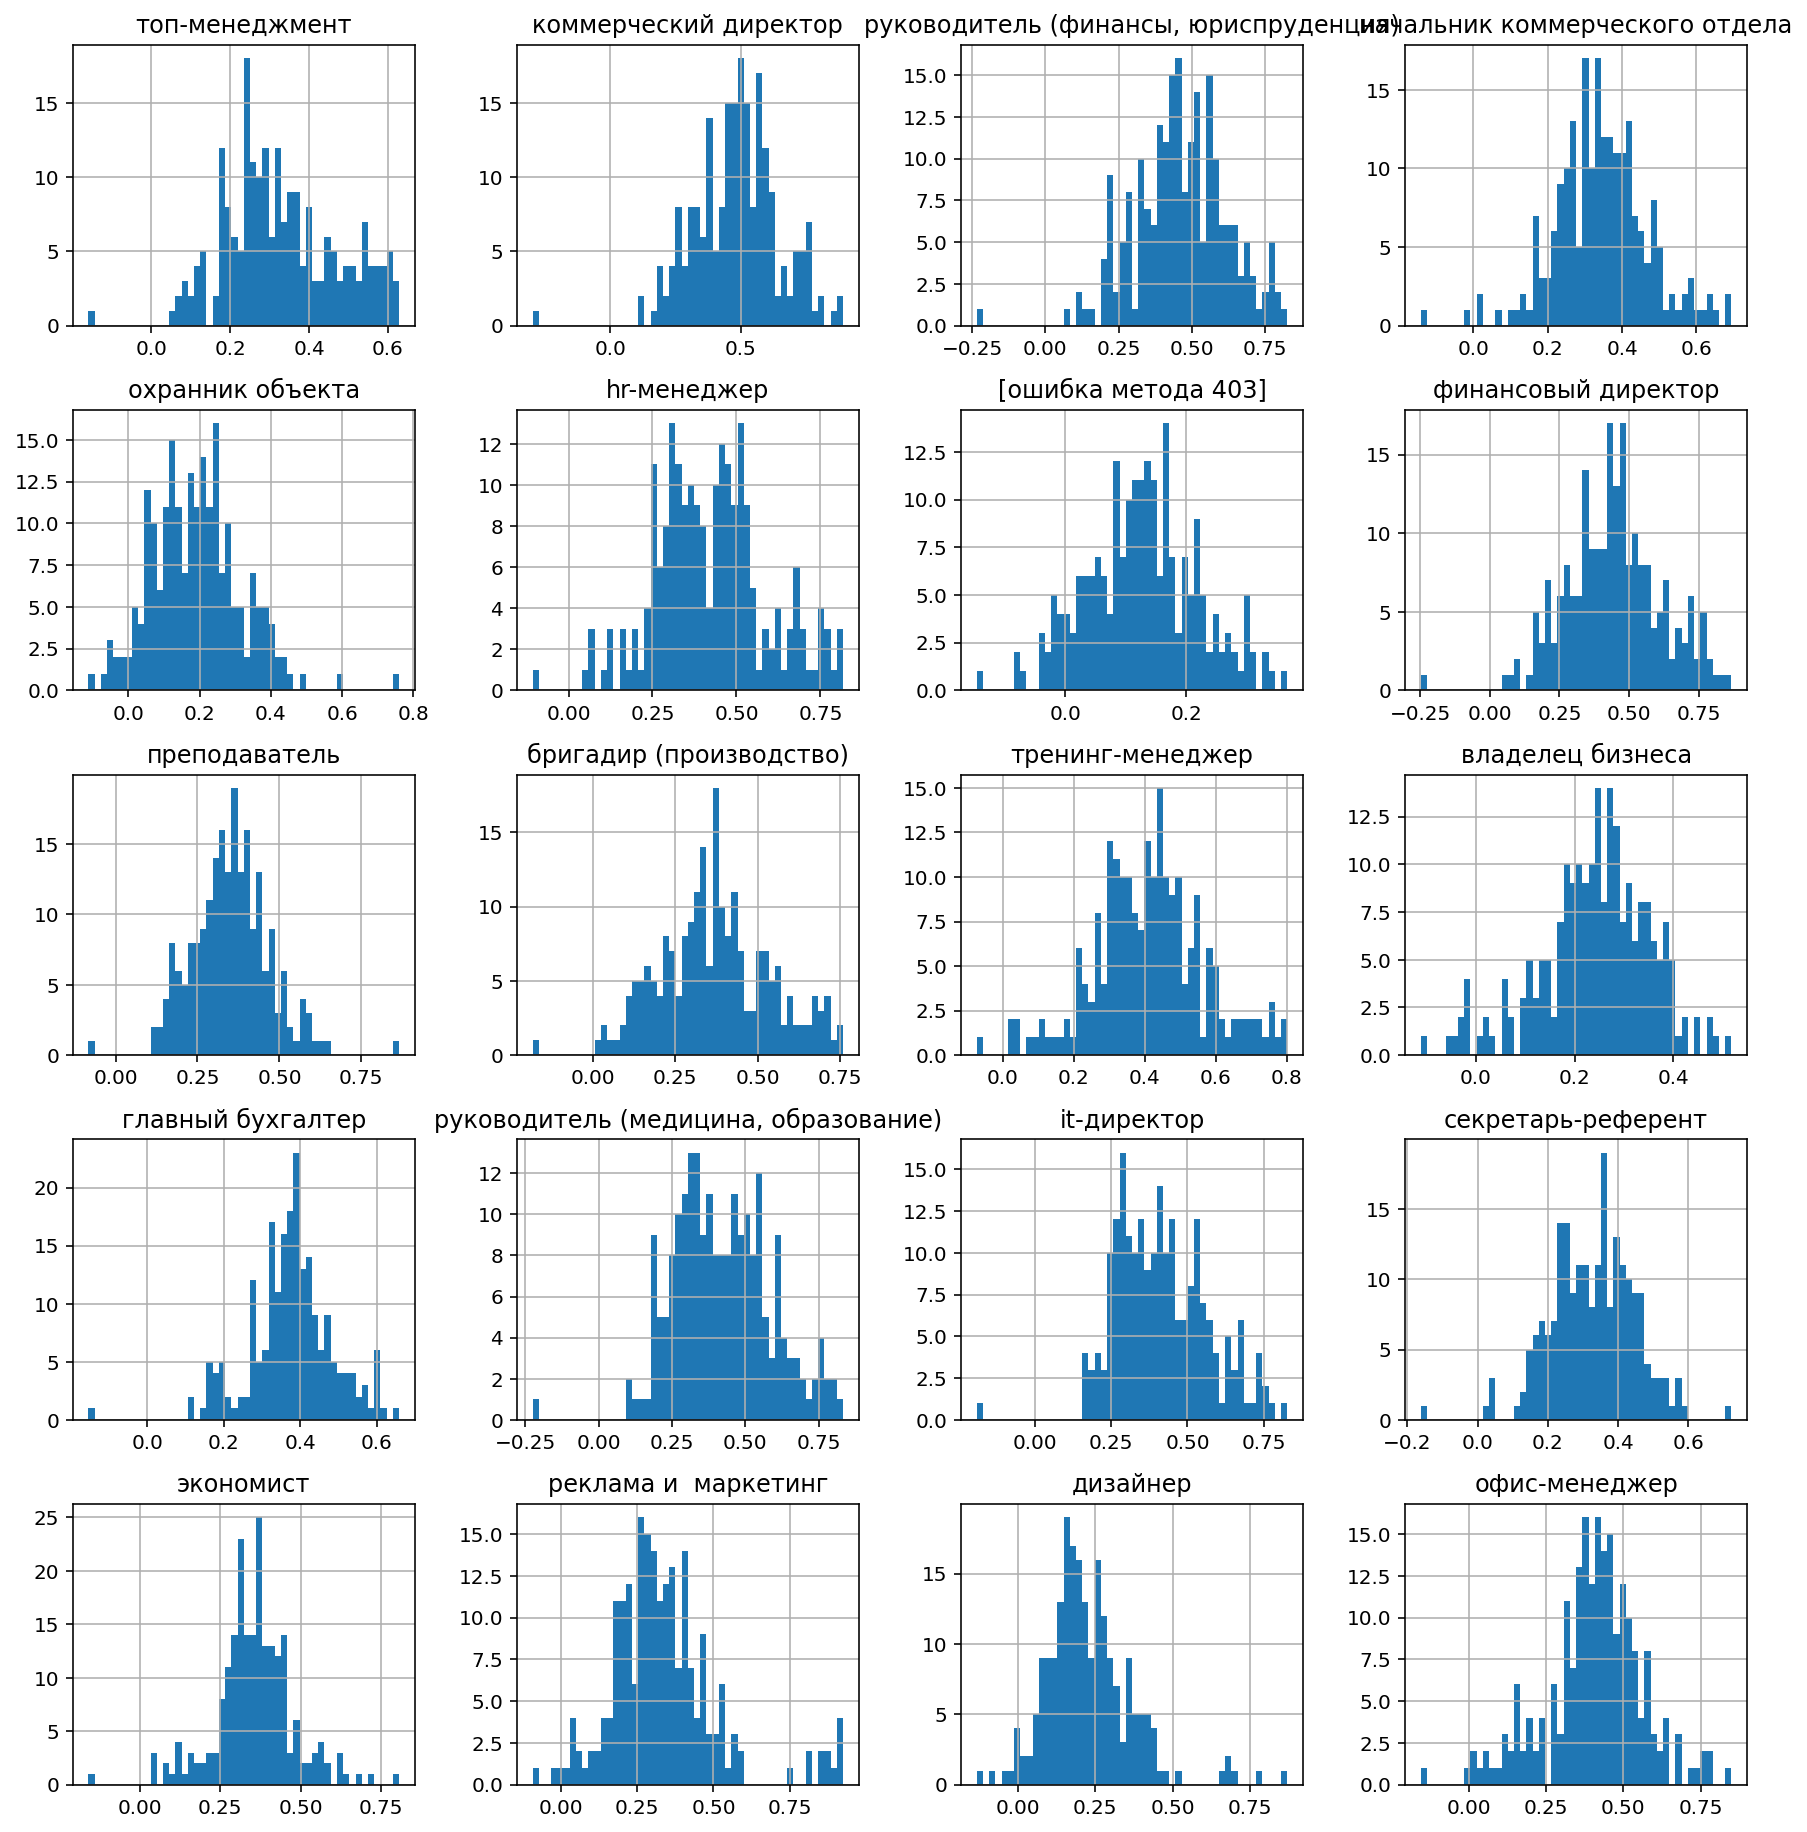

In [58]:
b2b_dist_a.iloc[:, :20].hist(bins=50, figsize=(15,16))
plt.show()

In [59]:
b2b_dist_a.iloc[:, :20].describe()

,топ-менеджмент,коммерческий директор,"руководитель (финансы, юриспруденция)",начальник коммерческого отдела,охранник объекта,hr-менеджер,[ошибка метода 403],финансовый директор,преподаватель,бригадир (производство),тренинг-менеджер,владелец бизнеса,главный бухгалтер,"руководитель (медицина, образование)",it-директор,секретарь-референт,экономист,реклама и маркетинг,дизайнер,офис-менеджер
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.329128,0.483821,0.461499,0.344860,0.191959,0.423351,0.127661,0.445191,0.351993,0.369926,0.411658,0.242651,0.376045,0.422528,0.416442,0.328266,0.356490,0.338505,0.228309,0.406897
std,0.142477,0.162995,0.158498,0.124814,0.125664,0.164797,0.091547,0.171052,0.118292,0.167409,0.156409,0.111691,0.109863,0.163385,0.150648,0.119855,0.123466,0.178298,0.141103,0.156465
min,-0.159945,-0.298341,-0.234091,-0.141684,-0.111584,-0.107071,-0.146939,-0.247696,-0.082838,-0.183850,-0.074056,-0.111715,-0.153792,-0.224739,-0.191902,-0.161484,-0.160330,-0.091894,-0.132911,-0.154291
25%,0.236356,0.381903,0.372955,0.268852,0.104292,0.311249,0.065443,0.340156,0.277814,0.259532,0.312879,0.182115,0.319804,0.306246,0.302585,0.248508,0.299903,0.226034,0.144521,0.331867
50%,0.310652,0.491607,0.460087,0.342017,0.189340,0.415686,0.127226,0.442440,0.354043,0.368022,0.410039,0.247906,0.379124,0.408319,0.404085,0.334836,0.356956,0.312553,0.206819,0.417087
75%,0.428295,0.576429,0.564853,0.417255,0.264795,0.513399,0.181392,0.545536,0.420299,0.472295,0.494872,0.315811,0.431678,0.536304,0.521692,0.412239,0.421131,0.411020,0.301339,0.503696
max,0.628244,0.892456,0.824692,0.694059,0.759361,0.817725,0.367525,0.867693,0.865053,0.759612,0.801883,0.517887,0.658748,0.833311,0.827715,0.722544,0.805782,0.924501,0.870813,0.848938


#### cc_ru

In [60]:
b2b_dist_c = calculate_cosine_similarity(v_b2b_professions_c, v_prof_roles_c, b2b_professions)
b2b_dist_c.shape

(215, 82)

In [61]:
b2b_dist_c.head()

,топ-менеджмент,коммерческий директор,"руководитель (финансы, юриспруденция)",начальник коммерческого отдела,охранник объекта,hr-менеджер,[ошибка метода 403],финансовый директор,преподаватель,бригадир (производство),...,программист,руководитель (научно-исследовательская сфера),тренер,специалист по маркетинговым исследованиям,персонал и обучение,менеджер по рекламе,менеджер по оптовым продажам,директор по персоналу,директор по маркетингу,менеджер по сбыту
0,0.411859,0.490738,0.459225,0.322998,0.401504,0.176844,0.089718,0.519081,0.290385,0.445074,...,0.450062,0.324089,0.383416,0.111962,0.269427,0.143897,0.173125,0.107349,0.111036,0.161482
1,0.360226,0.531251,0.501723,0.356432,0.381084,0.215436,0.106796,0.554511,0.400806,0.509680,...,0.556930,0.356234,0.426668,0.128429,0.269290,0.150630,0.186388,0.126071,0.130715,0.181431
2,0.384474,0.559096,0.444935,0.437144,0.431323,0.199601,0.181501,0.562883,0.466920,0.595937,...,0.514089,0.308610,0.506570,0.178304,0.281743,0.209665,0.242725,0.181413,0.184245,0.251333
3,0.182041,0.236391,0.161473,0.278889,0.161386,0.261678,0.198028,0.209401,0.166908,0.212876,...,0.171822,0.127659,0.193593,0.922498,0.456124,0.931959,0.927784,0.921217,0.921952,0.910936
4,0.334413,0.610385,0.454846,0.444416,0.485102,0.257192,0.162147,0.626007,0.482179,0.463075,...,0.492461,0.343487,0.498762,0.125860,0.410146,0.162916,0.171931,0.185486,0.146982,0.173625


In [62]:
result_comparison_c = matching_overview(matrix=b2b_dist_c, 
                                        inputs=b2b_professions,
                                        inputs_docs=b2b_professions_docs,
                                        targets=prof_roles_labels,
                                        targets_docs=prof_roles_docs)

result_comparison_c.to_csv('../reports/b2b-hh_prof_roles_ccru.csv', index=False)
result_comparison_a.head(15)

,input,inout tokenized,output,output tokenized,max cos sim,mean cos sim,sem cos sim
0,топ-менеджмент,топ менеджмент,"стратегия, инвестиции, консалтинг менеджер/кон...",стратегия инвестиции консалтинг менеджер консу...,0.628244,0.329128,0.009717
1,коммерческий директор,коммерческий директор,"продажи, обслуживание клиентов коммерческий ди...",продажи обслуживание клиентов коммерческий дир...,0.892456,0.483821,0.011116
2,"руководитель (финансы, юриспруденция)",руководитель финансы юриспруденция,"финансы, бухгалтерия экономист",финансы бухгалтерия экономист,0.824692,0.461499,0.010809
3,начальник коммерческого отдела,начальник коммерческого отдела,информационные технологии руководитель проектов,информационные технологии руководитель проектов,0.694059,0.344860,0.008512
4,охранник объекта,охранник объекта,безопасность охранник,безопасность охранник,0.759361,0.191959,0.008570
5,hr-менеджер,hr менеджер,"маркетинг, реклама, pr менеджер по продажам, м...",маркетинг реклама pr менеджер по продажам мене...,0.817725,0.423351,0.011239
6,[ошибка метода 403],ошибка метода 403,информационные технологии тестировщик,информационные технологии тестировщик,0.367525,0.127661,0.006243
7,финансовый директор,финансовый директор,"финансы, бухгалтерия финансовый директор (cfo)",финансы бухгалтерия финансовый директор cfo,0.867693,0.445191,0.011666
8,преподаватель,преподаватель,"наука, образование учитель, преподаватель, пед...",наука образование учитель преподаватель педагог,0.865053,0.351993,0.008067
9,бригадир (производство),бригадир производство,"производство, сервисное обслуживание слесарь",производство сервисное обслуживание слесарь,0.759612,0.369926,0.011417


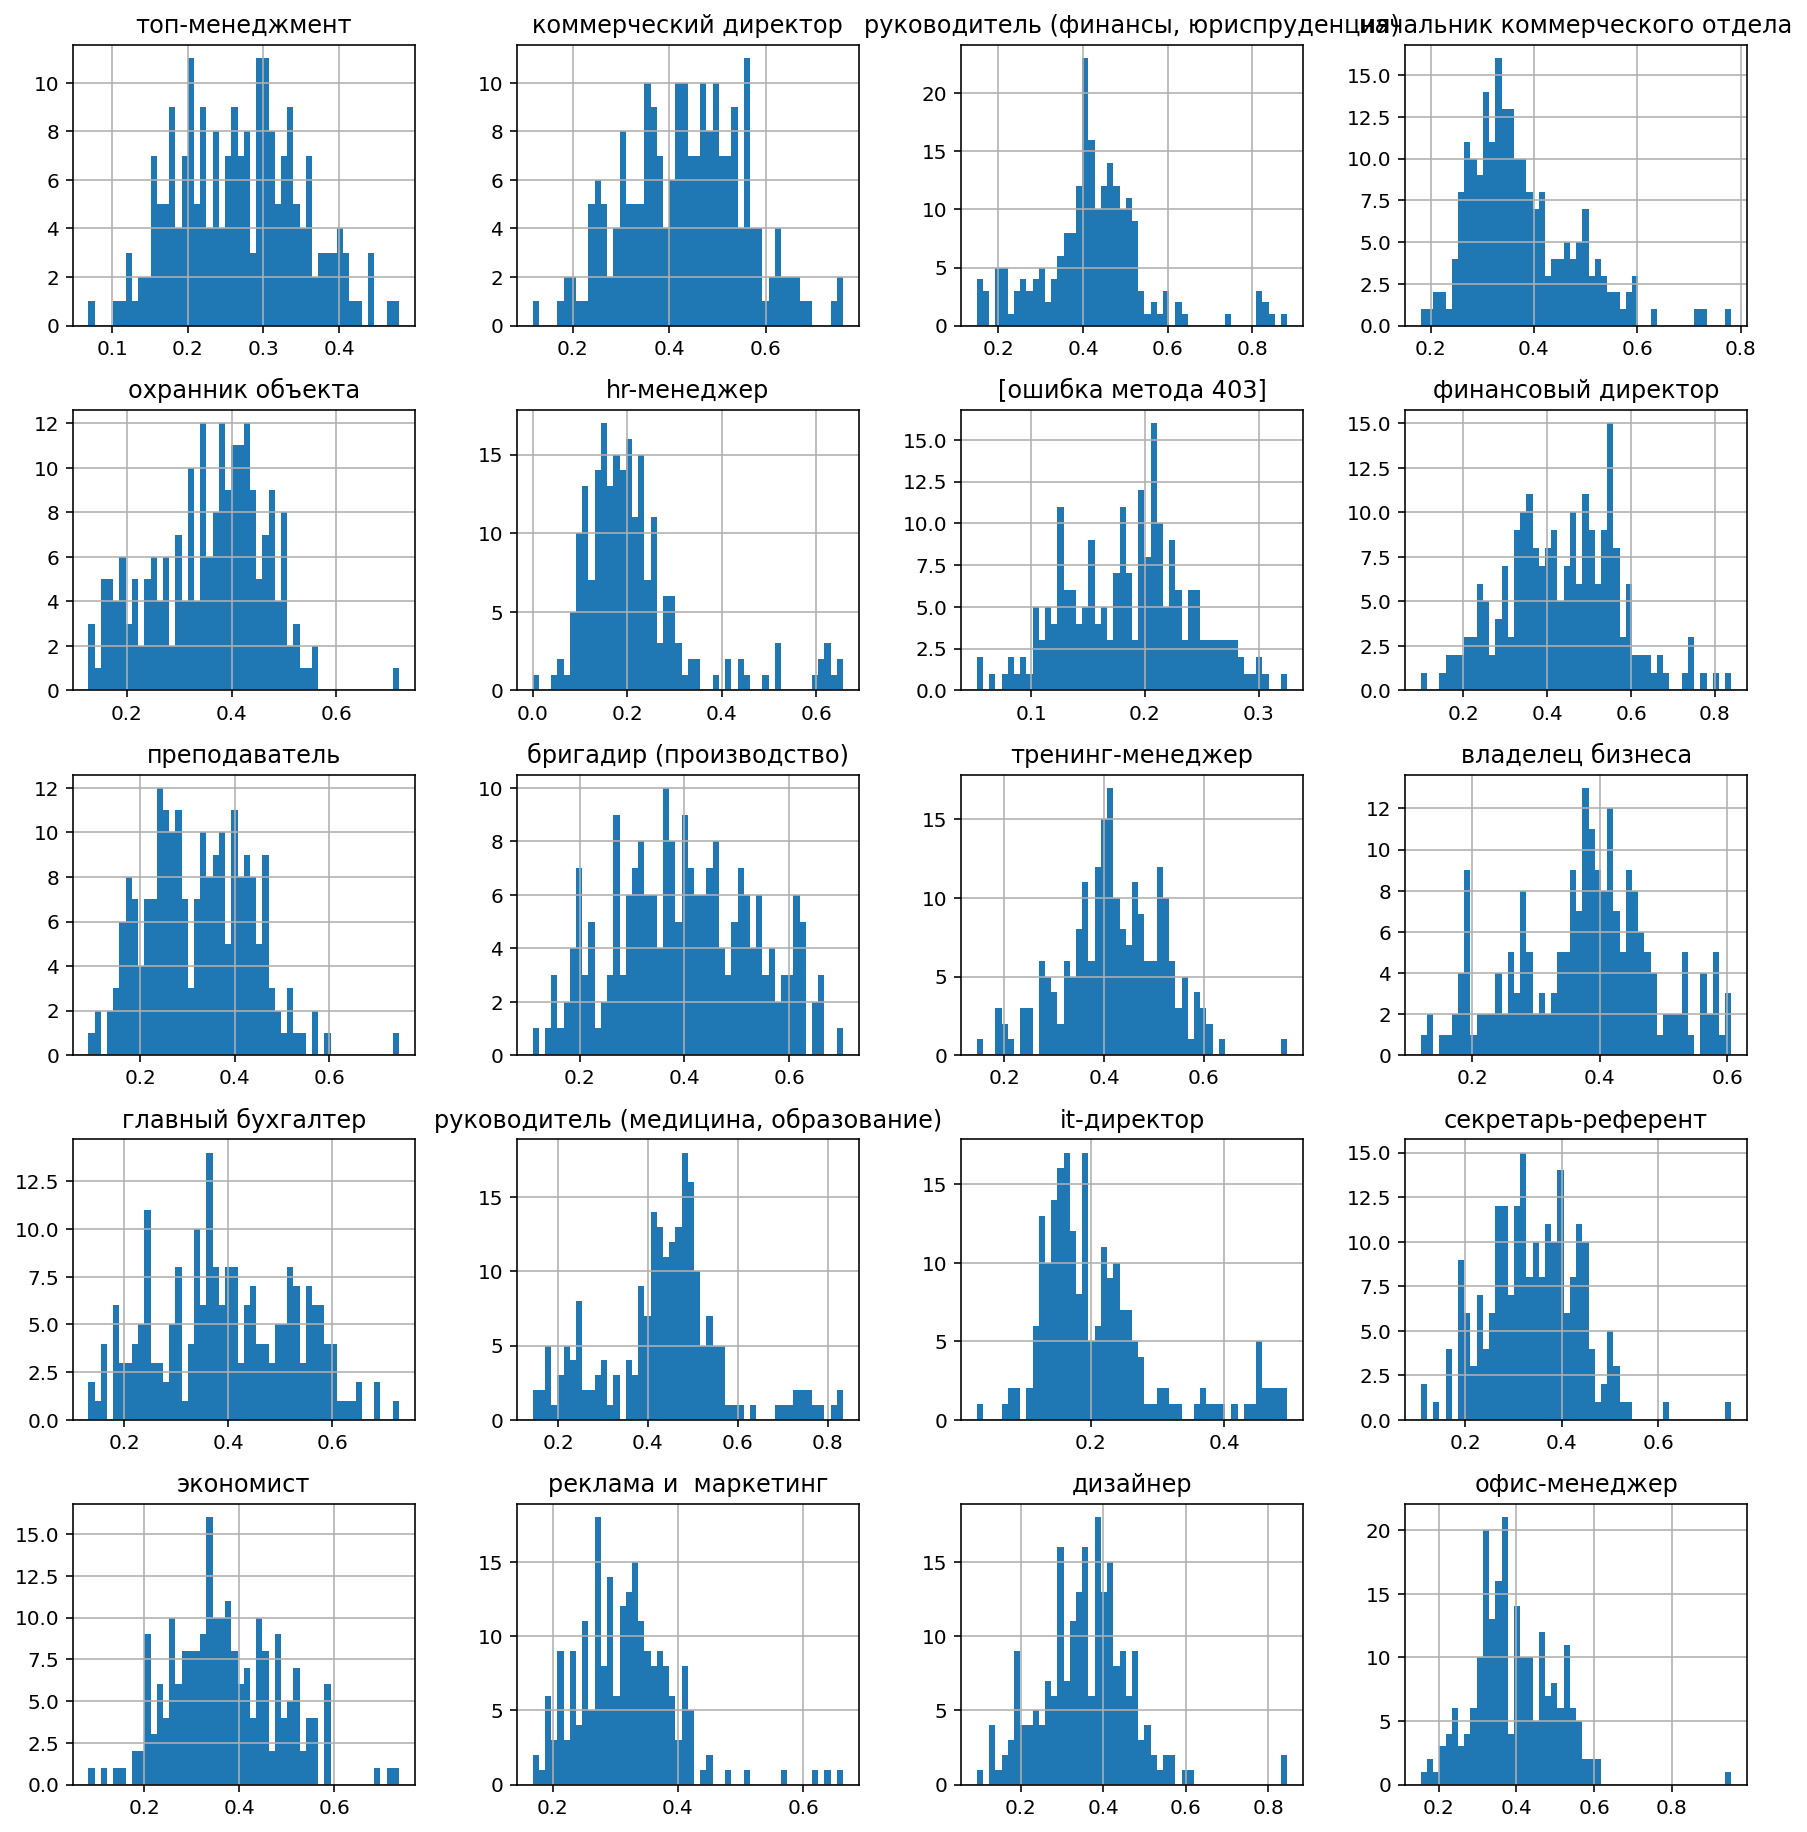

In [63]:
b2b_dist_c.iloc[:, :20].hist(bins=50, figsize=(15,16))
plt.show()

In [64]:
b2b_dist_c.iloc[:, :20].describe()

,топ-менеджмент,коммерческий директор,"руководитель (финансы, юриспруденция)",начальник коммерческого отдела,охранник объекта,hr-менеджер,[ошибка метода 403],финансовый директор,преподаватель,бригадир (производство),тренинг-менеджер,владелец бизнеса,главный бухгалтер,"руководитель (медицина, образование)",it-директор,секретарь-референт,экономист,реклама и маркетинг,дизайнер,офис-менеджер
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.268954,0.434309,0.421980,0.375921,0.358085,0.217375,0.186546,0.435051,0.324875,0.400852,0.421377,0.377461,0.399516,0.437130,0.212368,0.341254,0.371863,0.316038,0.357965,0.395448
std,0.080537,0.122466,0.127699,0.100763,0.107104,0.121142,0.054005,0.135363,0.109334,0.132169,0.098709,0.110003,0.131780,0.135530,0.092752,0.095864,0.113827,0.077534,0.109912,0.104549
min,0.068849,0.116833,0.148632,0.181166,0.126531,-0.000155,0.052258,0.098358,0.090134,0.110158,0.144680,0.119295,0.131542,0.143322,0.028503,0.108197,0.081935,0.167753,0.093450,0.153941
25%,0.204273,0.349077,0.363089,0.304609,0.279875,0.144551,0.144185,0.344699,0.243137,0.306256,0.364512,0.295738,0.300161,0.381979,0.151145,0.275322,0.293215,0.267753,0.293328,0.326596
50%,0.267476,0.436823,0.418261,0.356432,0.375482,0.193971,0.193491,0.437674,0.326766,0.400675,0.417325,0.384571,0.391012,0.450154,0.188780,0.339781,0.358192,0.314465,0.361289,0.374006
75%,0.324809,0.521739,0.483940,0.431317,0.432494,0.247208,0.222527,0.534307,0.407961,0.505989,0.493494,0.447949,0.511529,0.501194,0.241539,0.404544,0.448989,0.361454,0.423049,0.470306
max,0.478988,0.760163,0.882199,0.782180,0.719965,0.657208,0.324925,0.839167,0.747488,0.703071,0.767281,0.606385,0.728621,0.834768,0.494995,0.751491,0.736561,0.664088,0.846597,0.953754


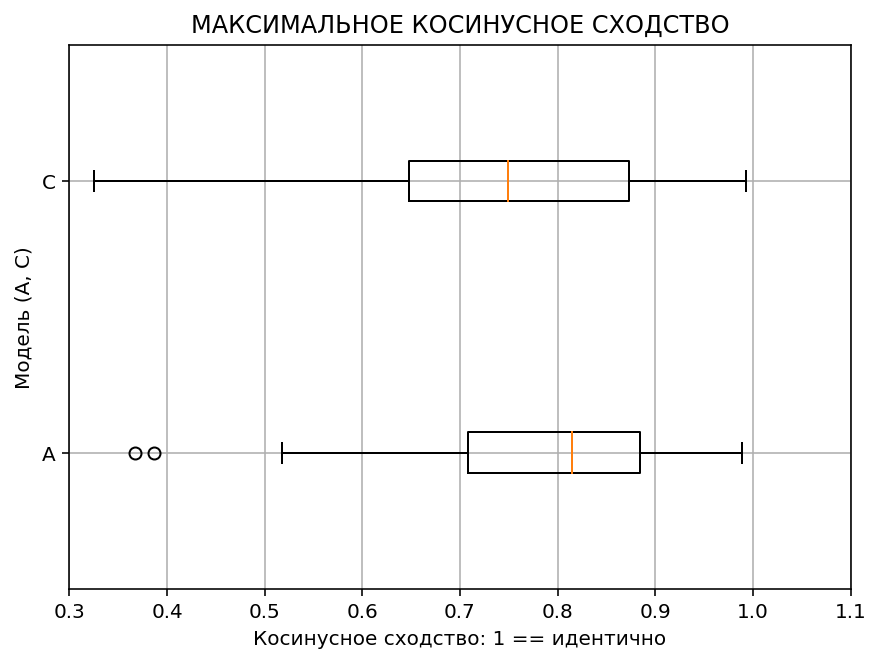

In [65]:
plt.figure(figsize=(7,5))
plt.boxplot(x=[b2b_dist_a.max(), b2b_dist_c.max()], 
            vert=False, labels=['A', 'C'])
plt.grid(visible=True)
plt.xlim(0.3,1.1)
plt.title('Максимальное косинусное сходство'.upper())
plt.ylabel('Модель (A, C)')
plt.xlabel('Косинусное сходство: 1 == идентично')
plt.show()

#### Выводы

Мы видим, что для однословных фраз (юрист, программист) разделение по расстоянию работает лучше. Наличие в названии обобщающих слов, таких как "директор", "менеджер", "специалист", "руководитель", "отдел" затрудняет выделение профессии. Предобученные модели не понимают аббревитатуры it, АХО и подобные.

### Оптимизация

#### Препроцессинг

Минимизируем количество слов в теримнах справоничка профессий. Примем за целевой справочник множество терминов из профессиональных ролей справочника hh.ru, при этом разобьем перечисленые через запятые термины на самостоятельные. Также выделим аббревиатуры в скобках.

Сделаем препроцессинг, который оставит в териманх только прилагательные и существительные. Уберем стоп-слова  "директор", "менеджер", "специалист", "руководитель". Приведем оставшиеся слова в нормальную форму. 

Оценим, как препроцессинг скажется на максимальной схожести терминов.

##### Профессии

Преобразуем справочник профессий hh в словарь профессиональных ролей:
- возьмем уникальные значения колонки ```prof_name```,
- разобьем на строки значения, содержащие перечисления через запятую,
- сделаем препроцессинг и сохраним документы для каждой профессии:
    - добавим к стоп-словам общие фразы: менеджер, специалист, руководитель, начальник, отдел, 
    - приведем слова к нормальной форме.

In [66]:
profession_labels = hh_profession_labels(prof_roles.prof_name.unique())
len(profession_labels)

194

In [67]:
profession_labels[:15]

['автомойщик',
 'автослесарь',
 'автомеханик',
 'мастер-приемщик',
 'менеджер по продажам',
 'менеджер по работе с клиентами',
 'администратор',
 'делопроизводитель',
 'архивариус',
 'курьер',
 'менеджер/руководитель ахо',
 'оператор пк',
 'оператор базы данных',
 'офис-менеджер',
 'переводчик']

Преобразуем метки в документы.

In [68]:
prof_docs = remove_stopwords(
    tokenize_texts(profession_labels, normalize=True)
)
len(prof_docs)

194

In [69]:
prof_docs[:25]

[['автомойщик'],
 ['автослесарь'],
 ['автомеханик'],
 ['мастер', 'приёмщик'],
 ['продажа'],
 ['клиент'],
 ['администратор'],
 ['делопроизводитель'],
 ['архивариус'],
 ['курьер'],
 [],
 ['пк'],
 ['база', 'данные'],
 ['офис'],
 ['переводчик'],
 ['секретарь'],
 ['помощник'],
 ['ассистент'],
 ['военнослужащий'],
 ['охранник'],
 ['полицейский'],
 ['информационный', 'безопасность'],
 ['служба', 'безопасность'],
 ['генеральный', 'директор'],
 ['исполнительный', 'директор']]

Удалим пустые документы и объединим неуникальные значения документов.

In [70]:
profession_labels, prof_docs = remove_empty_docs(profession_labels, prof_docs)
print('labels', len(profession_labels), 'docs', len(prof_docs))

labels 187 docs 187


In [71]:
profession_labels, prof_docs = unique_docs(profession_labels, prof_docs)
print('labels', len(profession_labels), 'docs', len(prof_docs))

labels 186 docs 186


In [72]:
profession_labels[:25]

['автомойщик',
 'автослесарь',
 'автомеханик',
 'мастер-приемщик',
 'менеджер по продажам, руководитель отдела продаж',
 'менеджер по работе с клиентами',
 'администратор',
 'делопроизводитель',
 'архивариус',
 'курьер',
 'оператор пк',
 'оператор базы данных',
 'офис-менеджер',
 'переводчик',
 'секретарь',
 'помощник руководителя',
 'ассистент',
 'военнослужащий',
 'охранник',
 'полицейский',
 'специалист по информационной безопасности',
 'специалист службы безопасности',
 'генеральный директор',
 'исполнительный директор',
 'директор по информационным технологиям']

In [73]:
prof_docs[:25]

[['автомойщик'],
 ['автослесарь'],
 ['автомеханик'],
 ['мастер', 'приёмщик'],
 ['продажа'],
 ['клиент'],
 ['администратор'],
 ['делопроизводитель'],
 ['архивариус'],
 ['курьер'],
 ['пк'],
 ['база', 'данные'],
 ['офис'],
 ['переводчик'],
 ['секретарь'],
 ['помощник'],
 ['ассистент'],
 ['военнослужащий'],
 ['охранник'],
 ['полицейский'],
 ['информационный', 'безопасность'],
 ['служба', 'безопасность'],
 ['генеральный', 'директор'],
 ['исполнительный', 'директор'],
 ['директор', 'информационный', 'технология']]

In [74]:
pd.Series(profession_labels, name='professions').to_csv('../datasets/processed/professions.csv')

##### Кем ты работаешь?

Подготовим ответы для сопоставления. В B2B названиях нам надо удалить первую часть до '|' и подготовить метки и документы для сопоставления.

In [75]:
input_labels = []
tmp_dict = dict()

for answer in b2b_answers.q61.unique():
    parts = answer.split('|')
    if len(parts) > 1:
        a_label = parts[1].lower().strip()
        if a_label not in tmp_dict:
            input_labels.append(a_label)
            tmp_dict[a_label] = 1

len(input_labels)

69

In [76]:
input_labels[:25]

['студент',
 'экономист',
 'руководитель (торговля, посредничество)',
 'коммерческий директор',
 'аналитик финансовый',
 'менеджер по продажам',
 'оператор (электроприборы, механизмы)',
 'специалист по маркетинговым исследованиям',
 'офис-менеджер',
 'менеджер по работе с клиентами',
 'pr-менеджер',
 'бухгалтер',
 'тренер',
 'дизайнер',
 'бригадир (производство)',
 'менеджер по рекламе',
 'руководитель (маркетинг, реклама)',
 'менеджер по подбору персонала',
 'финансовый директор',
 'брэнд-менеджер',
 'владелец бизнеса',
 'генеральный директор',
 'руководитель (медицина, образование)',
 'менеджер по логистике',
 'журналист']

Преобразуем метки в документы.

In [77]:
input_docs = remove_stopwords(
    tokenize_texts(input_labels, normalize=True)
)
len(input_docs)

69

In [78]:
input_docs[:25]

[['студент'],
 ['экономист'],
 ['торговля', 'посредничество'],
 ['коммерческий', 'директор'],
 ['аналитик', 'финансовый'],
 ['продажа'],
 ['электроприбор', 'механизм'],
 ['маркетинговый', 'исследование'],
 ['офис'],
 ['клиент'],
 [],
 ['бухгалтер'],
 ['тренер'],
 ['дизайнер'],
 ['бригадир', 'производство'],
 ['реклама'],
 ['маркетинг', 'реклама'],
 ['подбор', 'персонал'],
 ['финансовый', 'директор'],
 ['брэнд'],
 ['владелец', 'бизнес'],
 ['генеральный', 'директор'],
 ['медицина', 'образование'],
 ['логистика'],
 ['журналист']]

Удалим пустые документы

In [79]:
input_labels, input_docs = remove_empty_docs(input_labels, input_docs)
print('labels', len(input_labels), 'docs', len(input_docs))

labels 65 docs 65


#### Преобразование в векторное пространство

In [80]:
v_professions_a = docs_2_vec(model=a_model, documents=prof_docs)
v_professions_c = docs_2_vec(model=c_model, documents=prof_docs)

v_inputs_a = docs_2_vec(model=a_model, documents=input_docs)
v_inputs_c = docs_2_vec(model=c_model, documents=input_docs)

#### Визуализация

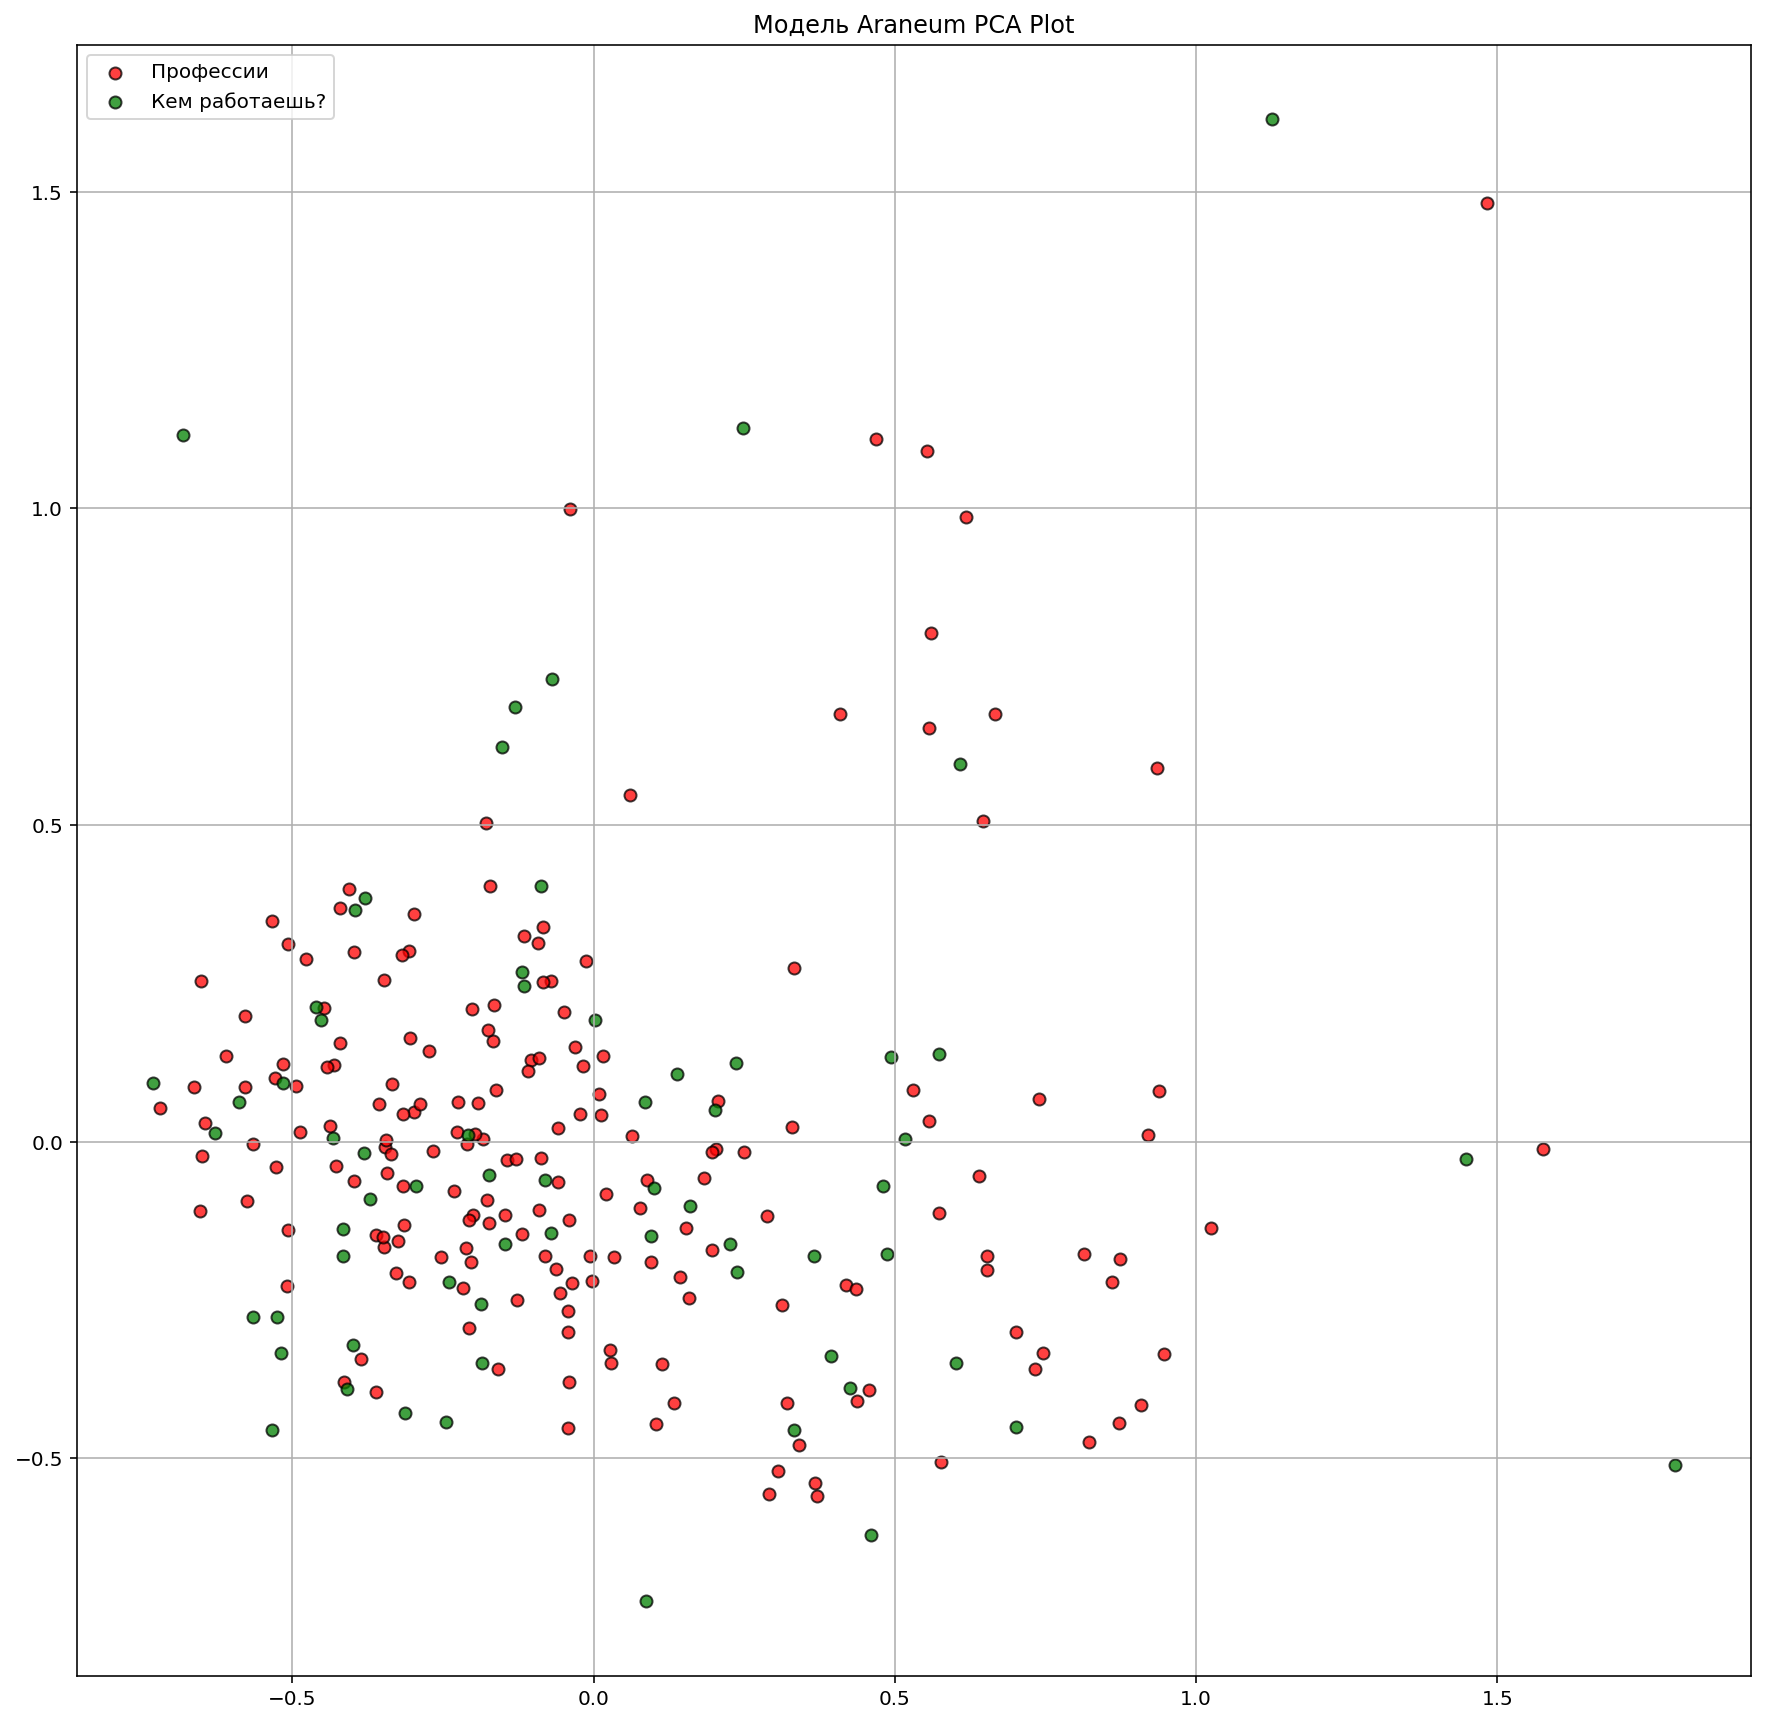

In [81]:
plt.figure(figsize=(15, 15))

# professions 
display_pca_scatterplot(vectors=v_professions_a, 
                        labels=profession_labels,
                        label='Профессии',
                        color='r', alpha=.75)

# b2b
display_pca_scatterplot(vectors=v_inputs_a, 
                        labels=input_labels,
                        label='Кем работаешь?',
                        color='g', alpha=.75)


plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель Araneum PCA Plot')
plt.show()

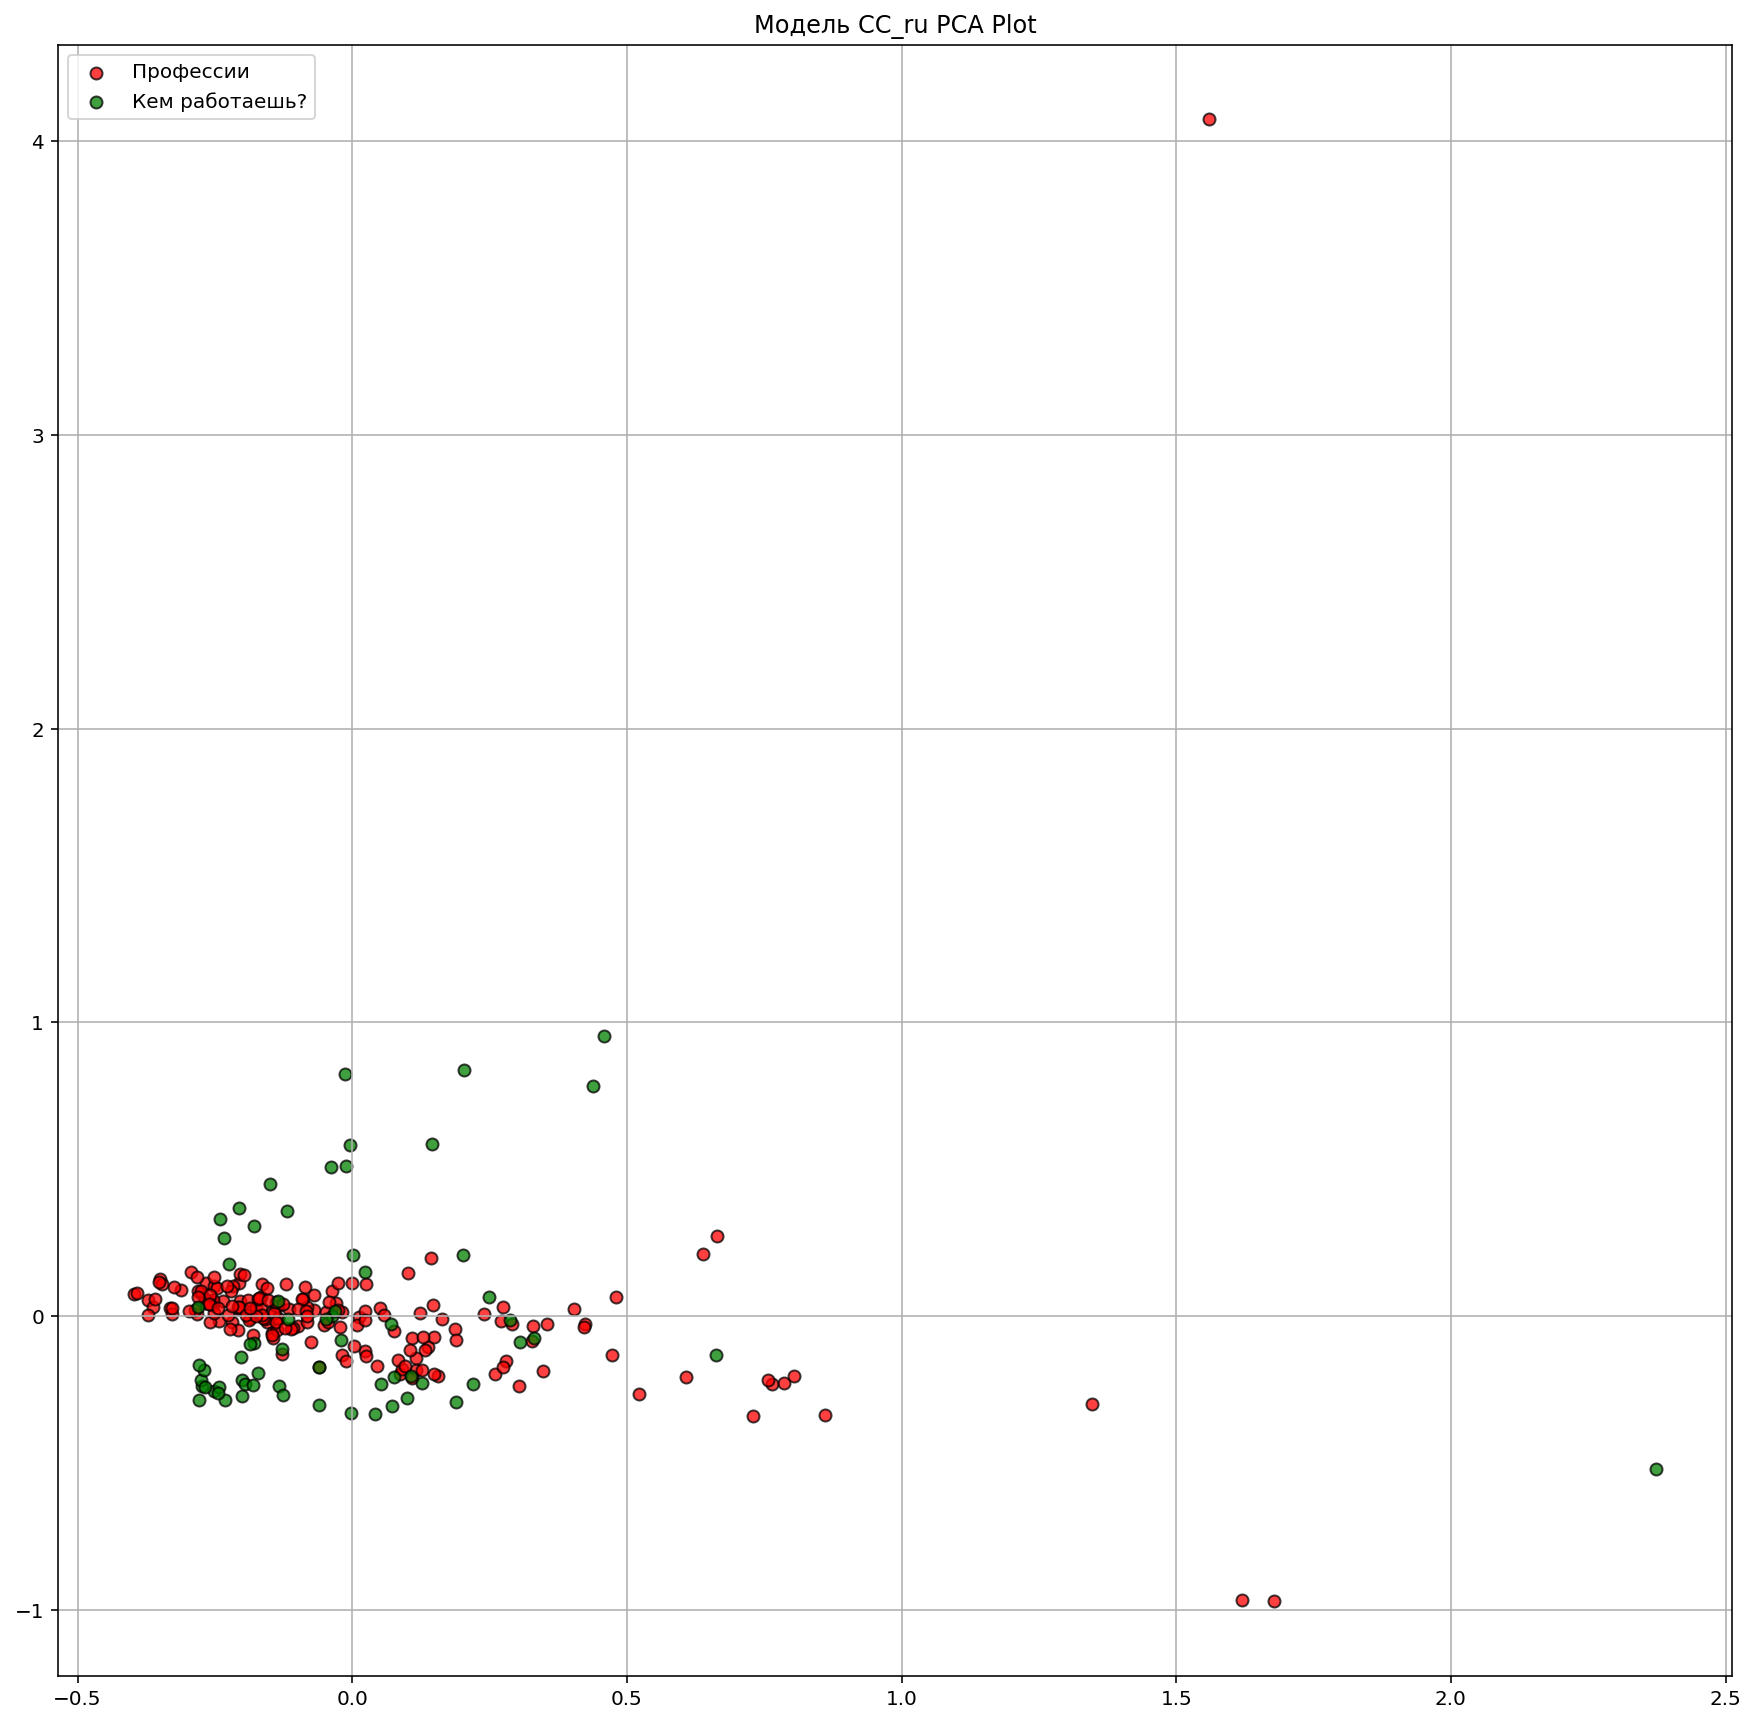

In [82]:
plt.figure(figsize=(15, 15))

# professions 
display_pca_scatterplot(vectors=v_professions_c, 
                        labels=profession_labels,
                        label='Профессии',
                        color='r', alpha=.75)

# b2b
display_pca_scatterplot(vectors=v_inputs_c, 
                        labels=input_labels,
                        label='Кем работаешь?',
                        color='g', alpha=.75)


plt.grid(visible = True)
plt.legend(loc='upper left')
plt.title('Модель CC_ru PCA Plot')
plt.show()

#### Сохранение векторов

In [83]:
v = export_to_projector(data=[v_professions_a, v_inputs_a], 
                        filename='../datasets/processed/v1/araneum_tsv')
v.shape

(251, 300)

In [84]:
v = export_to_projector(data=[v_professions_c, v_inputs_c], 
                        filename='../datasets/processed/v1/cc_ru_tsv')
v.shape

(251, 300)

In [85]:
profession_tokens = [[' '.join(words), 'profession tokens'] for words in prof_docs]
input_tokens = [[' '.join(words), 'input tokens'] for words in input_docs]
all_tokens = np.concatenate((profession_tokens, 
                             input_tokens), axis=0)
meta_data = pd.DataFrame(all_tokens, columns=['tokens', 'type'])
meta_data['labels'] = profession_labels + input_labels
meta_data.to_csv('../datasets/processed/v1/meta_data.tsv', sep='\t', index=False)
meta_data.shape

(251, 3)

Визуализация эмбедингов в [TensorFlow Embeding Projector](https://projector.tensorflow.org/?config=https://storage.yandexcloud.net/praktikumds/m01/v1/config.json)

### Анализ работы моделей и препроцессинга


#### Преобразование моделью Araneum

In [86]:
a_distances = calculate_cosine_similarity(v_inputs_a, v_professions_a, input_labels)

In [87]:
transormation_a = matching_overview(matrix=a_distances, 
                                    inputs=input_labels,
                                    inputs_docs=input_docs,
                                    targets=profession_labels,
                                    targets_docs=prof_docs)

transormation_a.to_csv('../reports/professions_araneum.csv', index=False)
transormation_a.head(15)

,input,inout tokenized,output,output tokenized,max cos sim,mean cos sim,sem cos sim
0,студент,студент,преподаватель,преподаватель,0.762572,0.210062,0.008470
1,экономист,экономист,экономист,экономист,1.000000,0.256897,0.011820
2,"руководитель (торговля, посредничество)",торговля посредничество,торговый представитель,торговый представитель,0.626534,0.163549,0.013482
3,коммерческий директор,коммерческий директор,коммерческий директор,коммерческий директор,1.000000,0.309384,0.016121
4,аналитик финансовый,аналитик финансовый,финансовый аналитик,финансовый аналитик,1.000000,0.243171,0.016392
5,менеджер по продажам,продажа,"менеджер по продажам, руководитель отдела продаж",продажа,1.000000,0.139008,0.012702
6,"оператор (электроприборы, механизмы)",электроприбор механизм,электромонтажник,электромонтажник,0.518228,0.147114,0.012004
7,специалист по маркетинговым исследованиям,маркетинговый исследование,инвестиционный аналитик,инвестиционный аналитик,0.709343,0.207278,0.016527
8,офис-менеджер,офис,офис-менеджер,офис,1.000000,0.184891,0.010094
9,менеджер по работе с клиентами,клиент,менеджер по работе с клиентами,клиент,1.000000,0.205133,0.011363


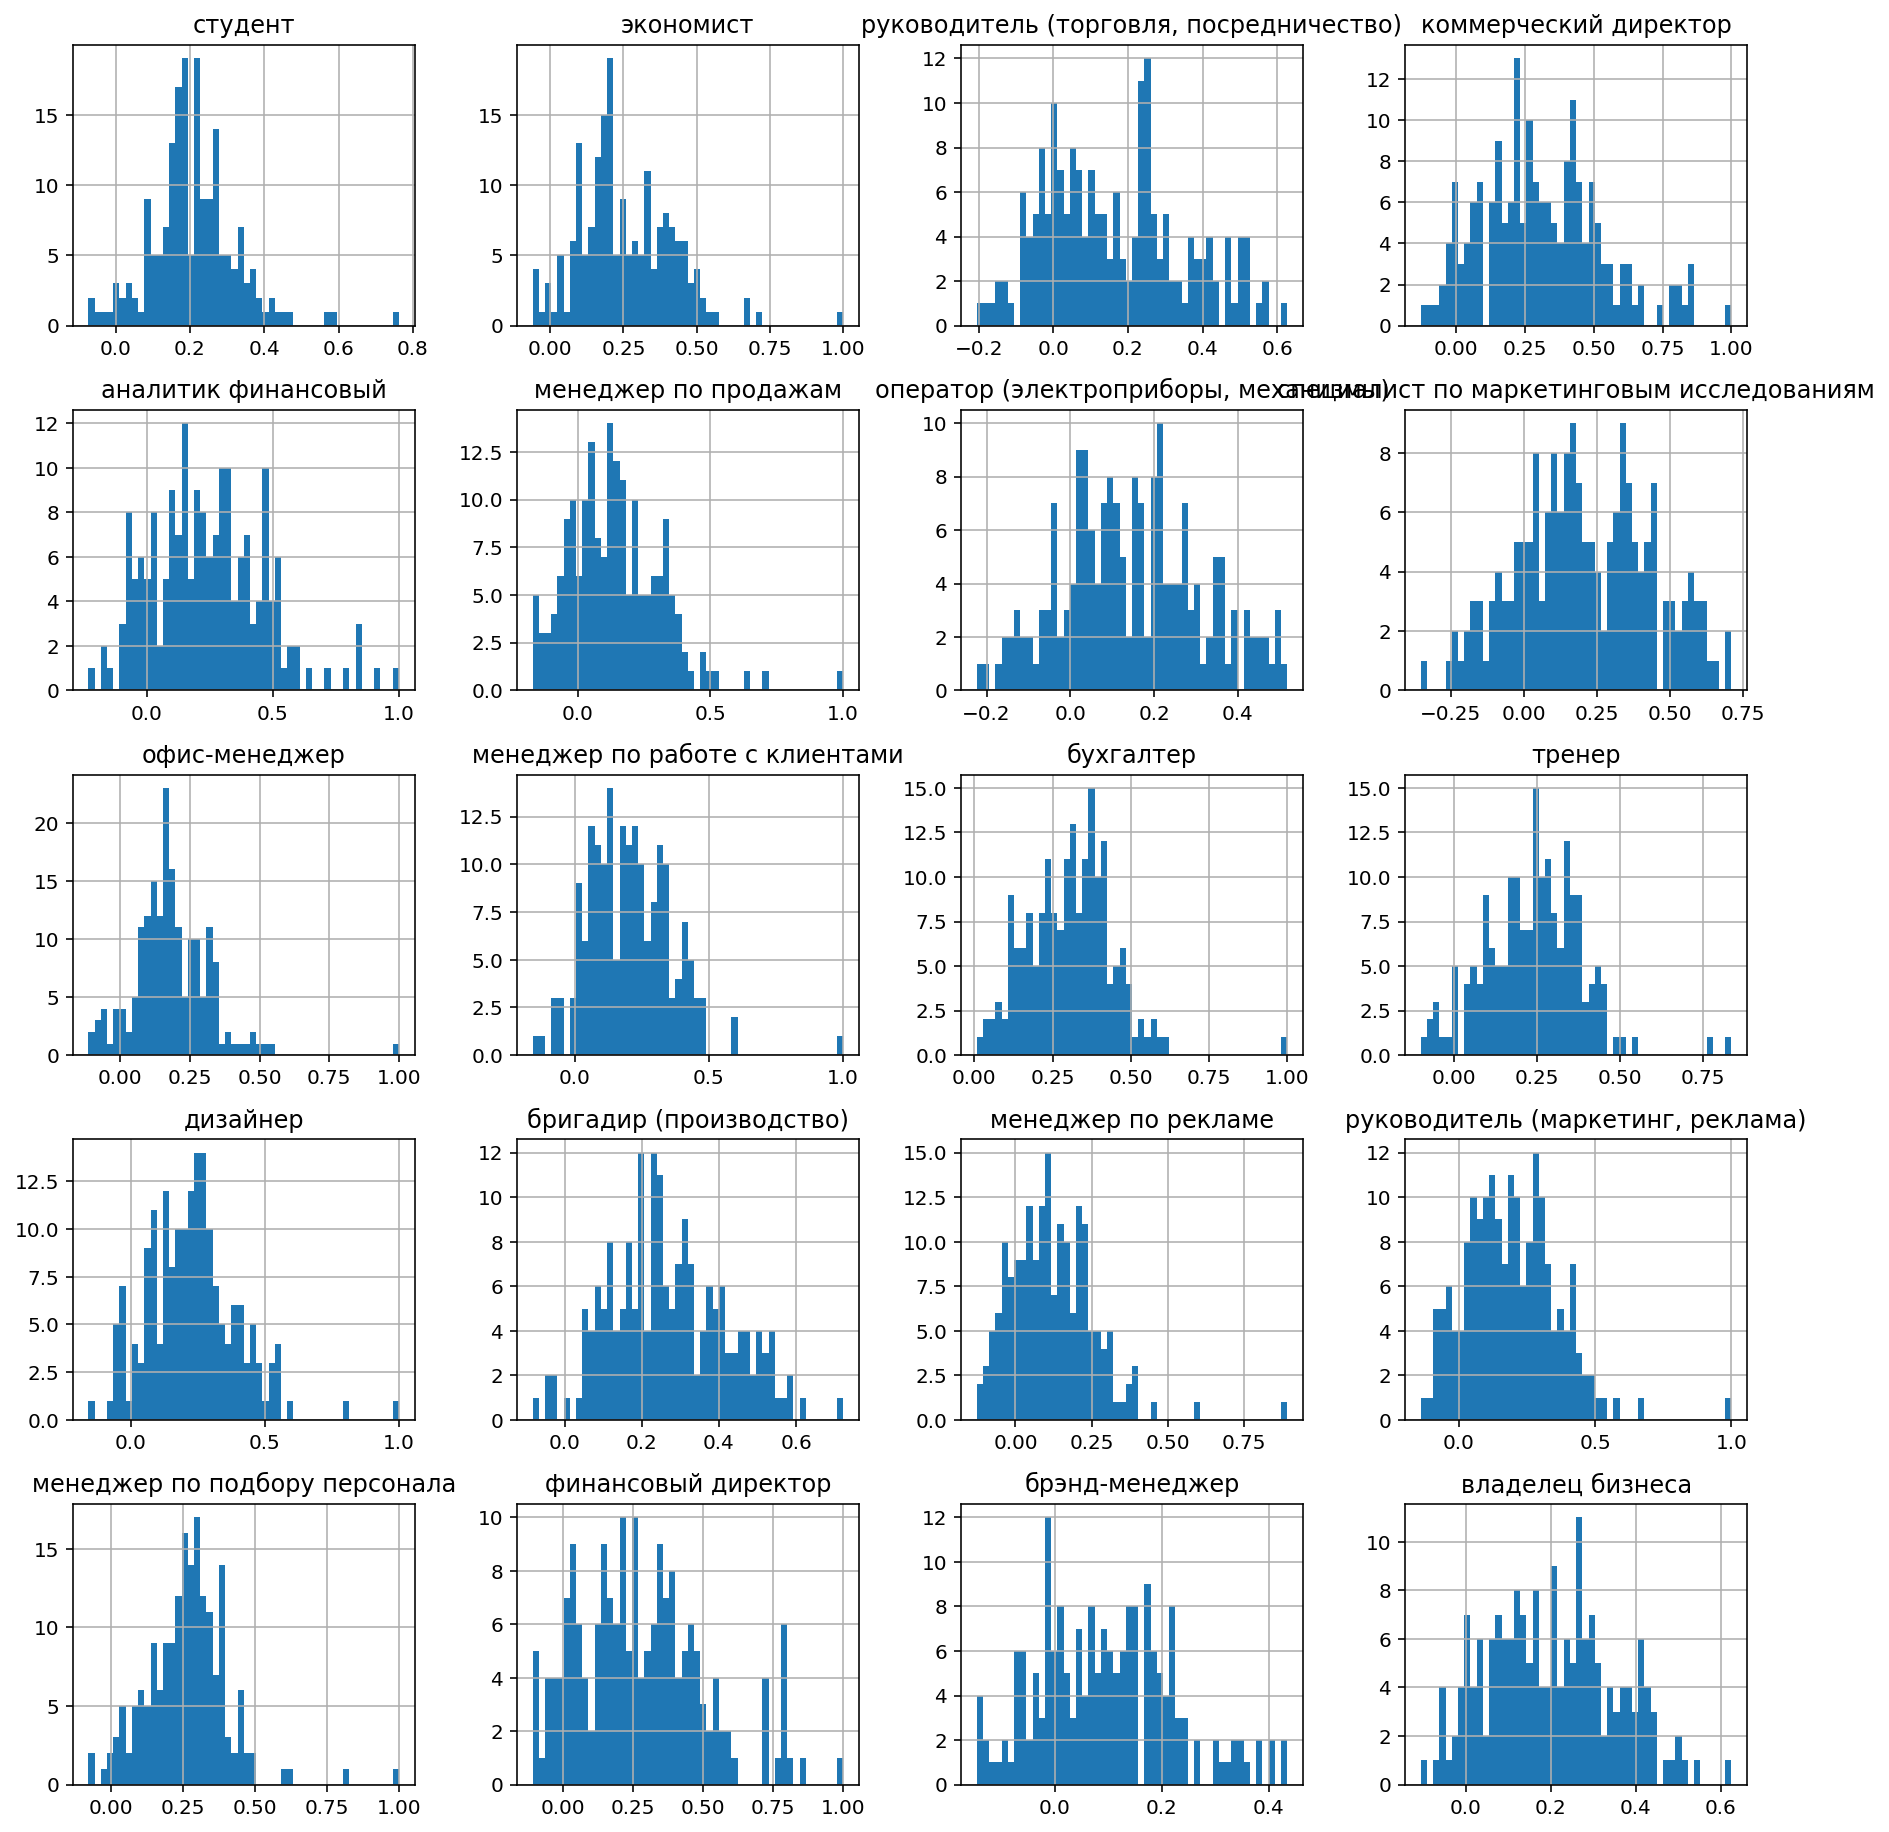

In [88]:
a_distances.iloc[:, :20].hist(bins=50, figsize=(15,16))
plt.show()

In [89]:
a_distances.iloc[:, :20].describe()

,студент,экономист,"руководитель (торговля, посредничество)",коммерческий директор,аналитик финансовый,менеджер по продажам,"оператор (электроприборы, механизмы)",специалист по маркетинговым исследованиям,офис-менеджер,менеджер по работе с клиентами,бухгалтер,тренер,дизайнер,бригадир (производство),менеджер по рекламе,"руководитель (маркетинг, реклама)",менеджер по подбору персонала,финансовый директор,брэнд-менеджер,владелец бизнеса
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.210062,0.256897,0.163549,0.309384,0.243171,0.139008,0.147114,0.207278,0.184891,0.205133,0.305847,0.239107,0.229425,0.269383,0.121896,0.193823,0.263650,0.278084,0.095250,0.201606
std,0.115517,0.161205,0.183868,0.219856,0.223556,0.173230,0.163706,0.225402,0.137665,0.154964,0.134993,0.142521,0.166065,0.150794,0.136974,0.166829,0.140042,0.226936,0.126304,0.147166
min,-0.072954,-0.060307,-0.205244,-0.129132,-0.230434,-0.169264,-0.223668,-0.351824,-0.113840,-0.157409,0.007370,-0.098713,-0.157841,-0.083716,-0.127037,-0.139632,-0.077601,-0.107725,-0.145834,-0.106003
25%,0.148406,0.152511,0.014701,0.154912,0.090405,0.022123,0.030740,0.043845,0.106018,0.091085,0.211591,0.145063,0.122924,0.160177,0.023659,0.075989,0.190949,0.115532,0.000038,0.090732
50%,0.201600,0.224745,0.140833,0.288056,0.226722,0.127779,0.143667,0.186055,0.172981,0.193189,0.311421,0.246489,0.224872,0.244976,0.109848,0.182498,0.268645,0.248206,0.090496,0.200623
75%,0.270605,0.375097,0.269689,0.450835,0.385447,0.238067,0.257007,0.366718,0.263975,0.312085,0.390057,0.336153,0.312253,0.374957,0.208931,0.304956,0.339909,0.408862,0.178456,0.300687
max,0.762572,1.000000,0.626534,1.000000,1.000000,1.000000,0.518228,0.709343,1.000000,1.000000,1.000000,0.835666,1.000000,0.722181,0.891572,1.000000,1.000000,1.000000,0.434781,0.625376


#### Преобразование моделью cc_ru

In [90]:
c_distances = calculate_cosine_similarity(v_inputs_c, v_professions_c, input_labels)

In [91]:
transormation_c = matching_overview(matrix=c_distances, 
                                    inputs=input_labels,
                                    inputs_docs=input_docs,
                                    targets=profession_labels,
                                    targets_docs=prof_docs)

transormation_c.to_csv('../reports/professions_cc_ru.csv', index=False)
transormation_c.head(15)

,input,inout tokenized,output,output tokenized,max cos sim,mean cos sim,sem cos sim
0,студент,студент,преподаватель,преподаватель,0.718742,0.343232,0.008980
1,экономист,экономист,экономист,экономист,1.000000,0.411090,0.011410
2,"руководитель (торговля, посредничество)",торговля посредничество,менеджер по маркетингу и рекламе,маркетинг реклама,0.555423,0.200934,0.007354
3,коммерческий директор,коммерческий директор,коммерческий директор,коммерческий директор,1.000000,0.451156,0.011774
4,аналитик финансовый,аналитик финансовый,финансовый аналитик,финансовый аналитик,1.000000,0.424466,0.011102
5,менеджер по продажам,продажа,"менеджер по продажам, руководитель отдела продаж",продажа,1.000000,0.137444,0.009537
6,"оператор (электроприборы, механизмы)",электроприбор механизм,оператор станков с чпу,станок,0.525920,0.267756,0.006328
7,специалист по маркетинговым исследованиям,маркетинговый исследование,директор по маркетингу и pr,директор маркетинг,0.591834,0.285927,0.008123
8,офис-менеджер,офис,офис-менеджер,офис,1.000000,0.267252,0.007923
9,менеджер по работе с клиентами,клиент,менеджер по работе с клиентами,клиент,1.000000,0.353364,0.008025


### Выводы

Сравним распределение максимального сходства между входным и целевым терминами для рассмотренных в анализе моделей и методов препроцессинга.

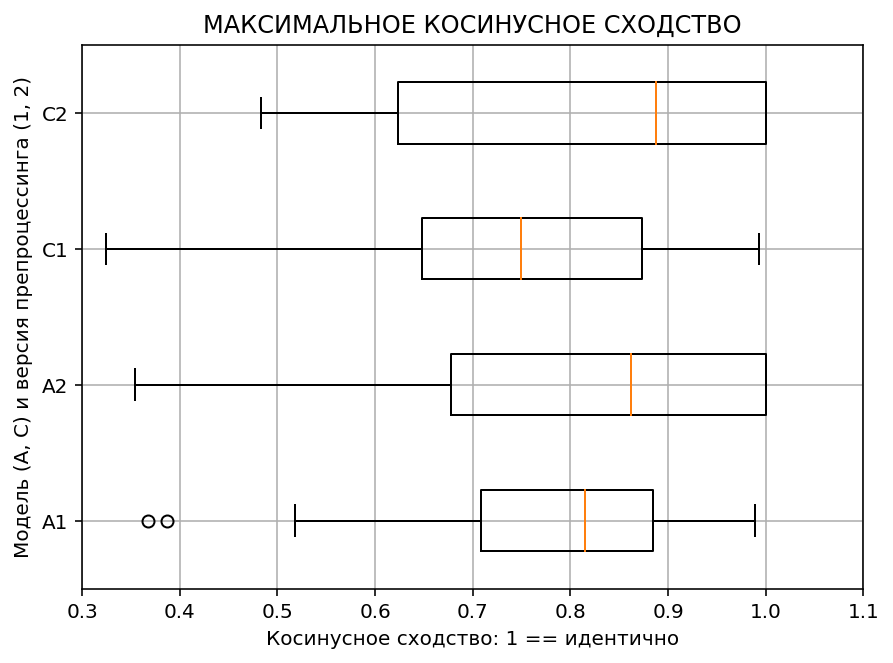

In [92]:
plt.figure(figsize=(7,5))
plt.boxplot(x=[b2b_dist_a.max(), a_distances.max(), b2b_dist_c.max(), c_distances.max()], 
            vert=False, labels=['A1', 'A2', 'C1', 'C2'])
plt.grid(visible=True)
plt.xlim(0.3,1.1)
plt.title('Максимальное косинусное сходство'.upper())
plt.ylabel('Модель (A, C) и версия препроцессинга (1, 2)')
plt.xlabel('Косинусное сходство: 1 == идентично')
plt.show()

Мы видим, что наибольшее медианное значение максимальной схожести дает модель cc.ru.300. Для нее у половины объектов найдены целевые теримины, косинусное сходство для которых больше 0.89.

In [93]:
c_distances.max().describe()

count    65.000000
mean      0.829031
std       0.187395
min       0.483224
25%       0.623777
50%       0.887571
75%       1.000000
max       1.000000
dtype: float64

## Общий вывод

Мы рассмотрели способ преобразования ответов на открытый вопрос "Кем ты рабоатешь" в значение справочника профессиий, основанный на преобразовании текста в эмбединги и подбора пары с наименьшим косинусным расстоянием.

В данном анализе в качестве входных терминов мы использовали ответы на вопрос "Кем ты работаешь" из b2b части датасета как мнее шумного. В этих ответах нет шума, поскольку ответ выбирался из ограниченного набора значений. Так мы оценили пригодность подхода, основанного на эмбедингах, для сопоставления теримнов из разных множеств друг другу. 

Для преобразования текста в эмбединги мы использовали предобученные модели с архитектурой fasttext araneum и cc.ru.300. 

Мы видим, что предобученные на текстах общей тематитики модели плохо различают профессии, не знают некоторые аббревиатуры. Мы видим, что значимо на результаты сопоставления сказывается препроцессинг, в котором из терминов удаляются все части речи кроме существительных и прилагательных и оставшиеся слова приодятся к номральной форме. Также хорошо сказывается удаление общих слов "менежер", "руководитель" и тп. 

Поскольку у нас нет тестового набора данных, мы не можем дать оценку пригодности этого метода. Также не можем оценить преимущества или недостаки трансформации в эмбединги со сравнением нормальных форм токенов.

Отдельно обратим внимание на неоднозначности сопоставления входных теримнов со значениями из справочника, вызванных семантической неопределенностью:
- ```тренер``` это ```фитнес-тренер``` или ```бизнес-тренер```?
- ```бригадир``` это ```прораб``` или ```начальник проиводства```?
- ```оператор (электроприборы, механизмы)``` это ```электромонтажник``` или ```оператор станков с чпу```?

В защиту способа, основанном на анализе расстояния между эмбедингами можно сказать, что он дает нам численную метрику, характеризующую качество сравнения. С ее помощью мы можем выделить сравнения, похожие на ошибочные, и построить процесс настройки модели или препроцессинга для повышения итого качества.

### Следующие шаги

Применим метод сопоставления эмбеддингов для всегод датасета. Для максимального косинусного сходства возьмем границы 0, 0.6, 0.85, 1 и оценим, какое количество входных терминов попало в каждый интервал. 

Изучим возможности настройки препроцессинга и модели для повышения качества.

Изучим возможности создания тестового набора данных для оценки. 